#**A Study of the Epidemiological Trajectory of COVID-19 in African Countries**

The Corona Virus Disease (COVID-19) is an infectious disease which was first discovered in Wuhan, China in December 2019. It was declared a pandemic by the World Health Organization on 30th January 2020. As at late June, the virus has spread to more than 213 countries worldwide including African countries which form the focus of this project. 

In this project, I analysed COVID-19 data from African countries including data on the pandemic's trajectory, and indicators such as access to health facilities and devices, testing, testing policies, and lockdown policies. 

**The BIG IDEA questions are:**
1. What is the trend in COVID cases over the days under study? 
2. Can we predict the likelihood of occurrence and the rate of occurrence of a COVID case, in a country, in the near future?   
3. What are the patterns in how the indicators in the datasets relate over time?  
4. Can we predict the likelihood of occurrence of a COVID case considering information obtained from existing patients? 

The datasets needed for this project were mainly gathered from  [Our World in Data](https://ourworldindata.org), the [Centre for Systems Science and Engineering at Johns Hopkins University](https://github.com/CSSEGISandData) and the [World Health Organization (WHO)](https://www.who.int/). Some datasets were also obtained from [GitHub](https://github.com/)

# Import all needed libraries

In [ ]:
import pandas as pd
import sklearn 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import datetime
from datetime import timedelta
from datetime import datetime,timedelta
from scipy.optimize import curve_fit, fsolve
import nltk #to handle natural language processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.classify.scikitlearn import SklearnClassifier
nltk.download('stopwords')
nltk.download('punkt')
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder #convert class labels to binary
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LinearRegression #import LinearRegression from sklearn for question on Linear Regression models
from sklearn.model_selection import train_test_split #import train_test_split from sklearn to split the data to training and test data


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#Using Logistic Models to develop trends


*Activities and tools used:*

I developed logistic models that fit the trend in COVID-19 cases for particular Africa countries and otehr secleted non-African countries. This was done using the `total-cases-covid-19` dataset and extracting information on the initial date when COVID cases were recorded in each country under study. The timeline for this dataset was from as early as December 31st 2019 to as late as June 7th 2020.

I defined a function for the logistic model which took an estimation of the following parameters:
* infection speed
* day when maximum infection occurred
* total number of recorded infected people at the infection's end. 

I then used this logistic model function to develop logistic models for Africa as a whole, each African country and selected non-African countries. 




*Findings:*

###Preparing Dataset(s)

In [ ]:
#LOAD DATA
df_World_Logistic = pd.read_csv("total-cases-covid-19.csv")
# df_World_Logistic.rename(columns={ "Total confirmed cases (cases)":"Total confirmed cases of COVID-19 (cases)"}
#                          , inplace=True)
#lower case all
df_World_Logistic = df_World_Logistic.apply(lambda x: x.astype(str).str.lower() if(x.dtype == 'object') else x)
#convert to date time object
df_World_Logistic["Date"] = pd.to_datetime(df_World_Logistic["Date"])
df_World_Logistic.tail()

#check for duplicates 
#Missing data? duplications? what countries?
print("Number of duplications:", df_World_Logistic.duplicated().sum()) #no duplications
df_World_Logistic.isnull().sum()/df_World_Logistic.shape[0] #no missing data

Number of duplications: 0


Entity                                       0.0
Code                                         0.0
Date                                         0.0
Total confirmed cases of COVID-19 (cases)    0.0
dtype: float64

In [ ]:
#EXTRACT FOR AFRICA 
WA_list = ["Algeria","Angola","Benin","Botswana","Burkina Faso","Burundi","Cameroon","Cape Verde",
           "Central African Republic","Chad","Comoros","Congo-Brazzaville","Congo-Kinshasa","Cote d'Ivoire",
           "Djibouti","Egypt","Equatorial Guinea","Eritrea","Ethiopia","Gabon","Gambia","Ghana",
           "Guinea","Guinea Bissau","Kenya","Lesotho","Liberia","Libya","Madagascar","Malawi",
           "Mali","Mauritania","Mauritius","Morocco","Mozambique","Namibia","Niger","Nigeria","Rwanda"
           "Senegal","Seychelles","Sierra Leone","Somalia","South Africa","South Sudan","Sudan","Swaziland",
           "São Tomé and Príncipe","Tanzania","Togo","Tunisia","Uganda","Western Sahara","Zambia","Zimbabwe","Burkina Faso", "Cameroon", "Cote d’Ivoire", "Ghana", "Nigeria", 
            "Senegal", "Ivory Coast", "Côte d'Ivoire", "Benin", "Burkina Faso", "Cape Verde", 
            "Cabo Verde", "The Gambia", "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Guinea Bissau"
           "Ivory Coast", "Cote d’Ivoire", "Côte d'Ivoire", "Liberia", "Mali", 
           "Mauritania", "Niger", "Nigeria", "Senegal", "Sierra Leone","Togo",
           "Saint Helena","St Helena", "St. Helena","Sao Tome and Principe", 
           "Sao Tome & Principe", "Cameroon"]

#lowercase of each country name:
WA_list = [string.lower() for string in WA_list]
WAindexlist = []
counter = 0
for i in df_World_Logistic['Entity']:
  if i in WA_list:
      WAindexlist.append(counter)
  counter +=1
# print(WAindexlist)

#Extract those rows of the dataframe
df_Africa_Logistic = df_World_Logistic.loc[WAindexlist]
df_Africa_Logistic.head() #this is a seperate dataframe for only African countries, that we can use later on 
print("The number of African countries represented are", len(df_Africa_Logistic["Entity"].unique())) #all 52 african countries represented

The number of African countries represented are 52


In [ ]:
#FIND INITIAL DATES FOR AFRICAN COUNTRIES 
#findings first day that first case was recorded
#first make a list:
firsts = []
countries = []
df_Africa_Logistic.head(60)
df1 = df_Africa_Logistic.loc[df_Africa_Logistic['Total confirmed cases of COVID-19 (cases)']==1]
df1.head()
len(df1["Entity"].unique())

for index in df1.index:
    if df1["Entity"][index] not in countries:
      countries.append(df1["Entity"][index])
      if df1['Total confirmed cases of COVID-19 (cases)'][index] == 1:
        firsts.append([df1["Entity"][index],df1["Date"][index]])
print(firsts)

[['algeria', Timestamp('2020-02-26 00:00:00')], ['benin', Timestamp('2020-03-17 00:00:00')], ['cameroon', Timestamp('2020-03-07 00:00:00')], ['central african republic', Timestamp('2020-03-16 00:00:00')], ['chad', Timestamp('2020-03-20 00:00:00')], ['comoros', Timestamp('2020-05-02 00:00:00')], ["cote d'ivoire", Timestamp('2020-03-12 00:00:00')], ['djibouti', Timestamp('2020-03-19 00:00:00')], ['egypt', Timestamp('2020-02-15 00:00:00')], ['equatorial guinea', Timestamp('2020-03-15 00:00:00')], ['eritrea', Timestamp('2020-03-22 00:00:00')], ['ethiopia', Timestamp('2020-03-14 00:00:00')], ['gabon', Timestamp('2020-03-13 00:00:00')], ['gambia', Timestamp('2020-03-18 00:00:00')], ['guinea', Timestamp('2020-03-14 00:00:00')], ['kenya', Timestamp('2020-03-14 00:00:00')], ['lesotho', Timestamp('2020-05-15 00:00:00')], ['liberia', Timestamp('2020-03-17 00:00:00')], ['libya', Timestamp('2020-03-25 00:00:00')], ['mauritania', Timestamp('2020-03-15 00:00:00')], ['morocco', Timestamp('2020-03-03 0

In [ ]:
#FIND INITIAL DATES FOR NON-AFRICAN COUNTRIES 
#now extract for rest of countries you have not extracted for
countries_left=[]
for i in df_Africa_Logistic["Entity"].unique():
  if i not in [j[0] for j in firsts]:
    countries_left.append(i)

df2 = pd.DataFrame()
indexlist =[]

for index in df_Africa_Logistic.index:
    if df_Africa_Logistic["Entity"][index] in countries_left:
      indexlist.append(index)

df2 = df_Africa_Logistic.loc[indexlist]

df2.head()
df3 = pd.DataFrame()
templist = []
indexlist=[]
gameover = False

df2["Entity"].unique()

for i in countries_left:
  templist.append(i)
  # print(templist)
  # input()
  for index in df2.index:
     if df2["Entity"][index] in templist:
       indexlist.append(index)
    #  print(indexlist)
     df3 = df2.loc[indexlist]
  for index in df3.index:
    if gameover == False:
      firsts.append([df3["Entity"][index],df3["Date"][index]])
      gameover = True
  templist=[]
  indexlist=[]
  df3 = pd.DataFrame()
  gameover = False
print(len(firsts))

#convert to datetime object
initial_date = df_Africa_Logistic["Date"].unique()[0]
initial_date =  pd.to_datetime(initial_date)

52


###Logistic Curve (Africa & Specific African countries)

COVID is predicted to end in Africa 395 days after December 31, 2019


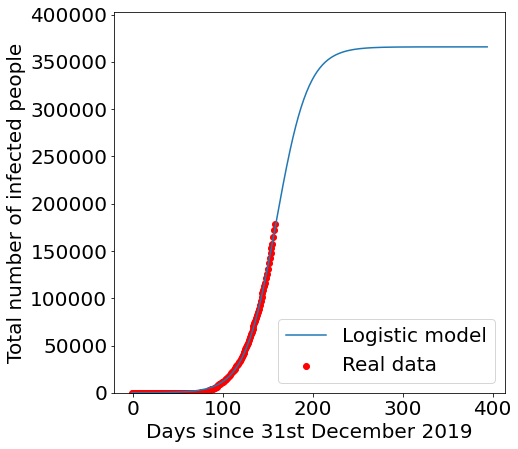

In [ ]:
#LOGISTIC CURVE FOR AFRICA AS A WHOLE
#the whole of Africa
#1. Data Preparation
#sum number of cases in the countries by date
extrapolate_Africa_cases = pd.DataFrame(df_Africa_Logistic.groupby(['Date'])["Total confirmed cases of COVID-19 (cases)"].sum()) #summed number of cases per day
extrapolate_Africa_cases = extrapolate_Africa_cases.add_suffix('Count').reset_index() #changed groupby to a dataframe
extrapolate_Africa_cases["Total confirmed cases of COVID-19 (cases)"] = extrapolate_Africa_cases.Date.dt.strftime('%Y-%m-%d %H:%M:%S')
extrapolate_Africa_cases

FMT = '%Y-%m-%d %H:%M:%S'
extrapolate_Africa_cases['Date'].apply(lambda x: x.strftime('%Y-%m-%d')) #change date to string objects first
extrapolate_Africa_cases.rename(columns={"Total confirmed cases of COVID-19 (cases)Count": "cases",
                                              "Total confirmed cases of COVID-19 (cases)": "date_str"}, inplace=True) #rename needed column
date = extrapolate_Africa_cases["date_str"] #store dates column                                              
extrapolate_Africa_cases['date_str'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days)
extrapolate_Africa_cases = extrapolate_Africa_cases.drop(columns=['Date'])

#2. Analyse using logistic model
#define the model
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a)) 
#a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end

#estimate the parameter values and errors starting from the original data.
x = list(extrapolate_Africa_cases.iloc[:,1])
y = list(extrapolate_Africa_cases.iloc[:,0])
fit = curve_fit(logistic_model,x,y,p0=[2,100,20000], maxfev=10000)
fit #gives values of a, b and c and the covariance matrix
fit = list(fit)
a = list(fit[0])[0]
b = list(fit[0])[1]
c = list(fit[0])[2]
cov_matrix = list(fit[1])

errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]] #gives standard error of a, b and c
errors
#The expected number of infected people at infection end is c +/- error[2].
#the infection will peak around ....?

sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b)) #finding the day when infection will end 
sol

print("COVID is predicted to end in Africa " + str(sol) + 
      " days after " + initial_date.strftime('%B %d, %Y'))
      
# str(sol) + " days after " + initial_date.strftime('%B %d, %Y'))

#4. Plot!
pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=20)
# Real data
plt.scatter(x,y,label="Real data",color="red")
# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )
# Predicted exponential curve
plt.legend()
plt.xlabel("Days since 31st December 2019")
plt.ylabel("Total number of infected people")
plt.ylim(min(y)*0.9,fit[0][2]*1.1)
plt.show()

COVID is predicted to end in ALGERIA 314 days after February 26, 2020


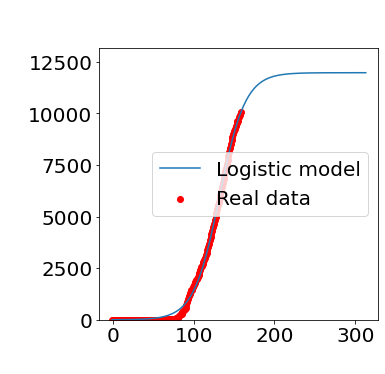

COVID is predicted to end in EGYPT 434 days after February 15, 2020


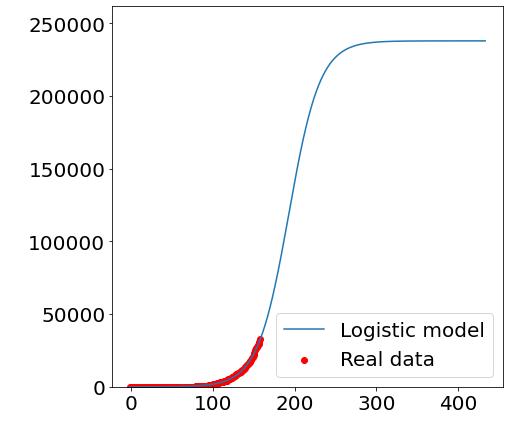

COVID is predicted to end in NIGERIA 260 days after February 28, 2020


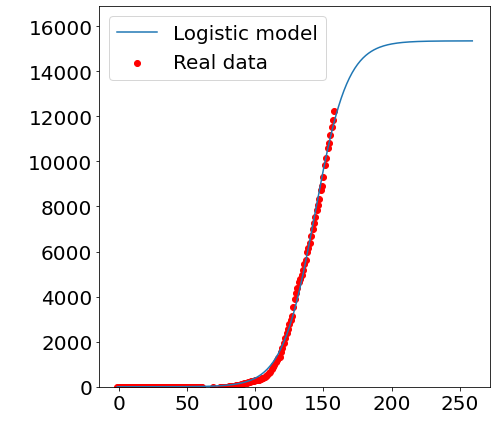

COVID is predicted to end in MOROCCO 273 days after March 03, 2020


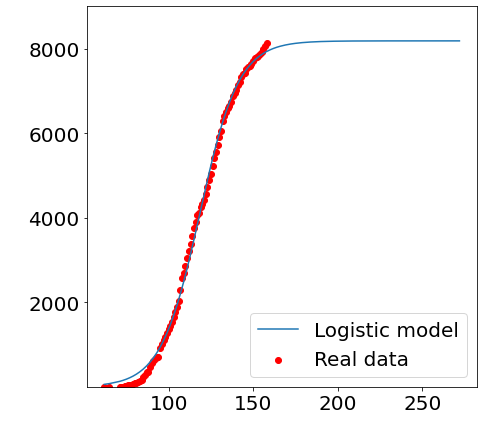

COVID is predicted to end in SENEGAL 249 days after March 03, 2020


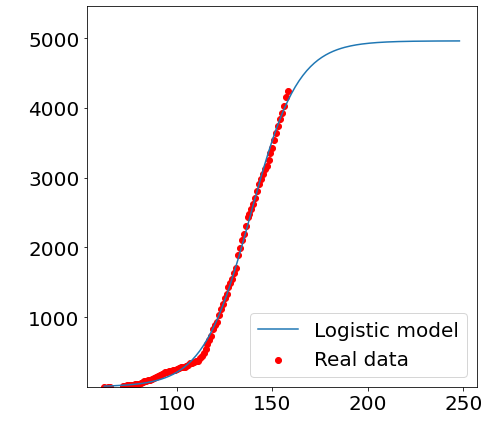

COVID is predicted to end in TUNISIA 152 days after March 03, 2020


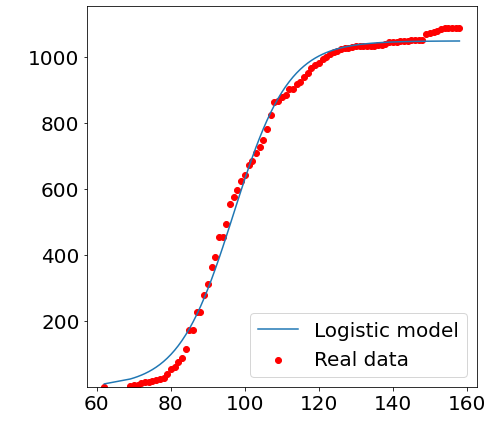

COVID is predicted to end in SOUTH AFRICA 500 days after March 06, 2020


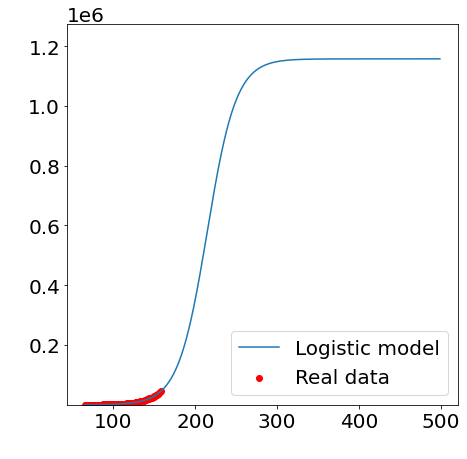

COVID is predicted to end in CAMEROON 405 days after March 07, 2020


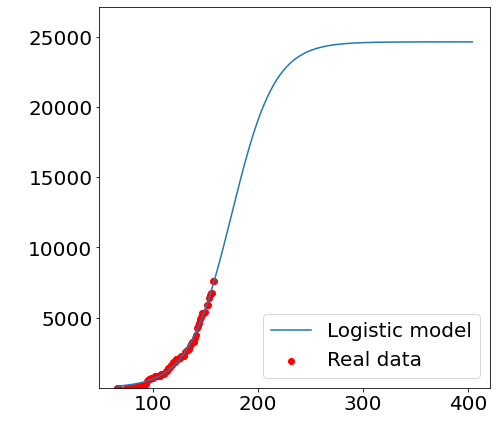

COVID is predicted to end in TOGO 266 days after March 07, 2020


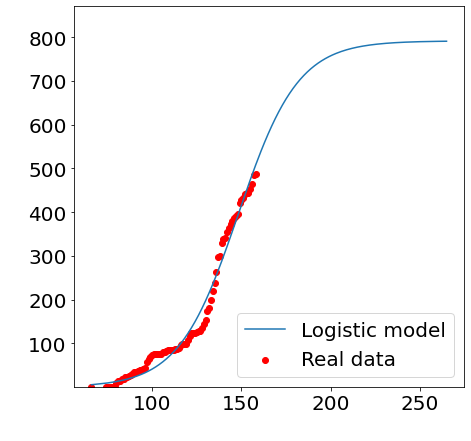

COVID is predicted to end in BURKINA FASO 187 days after March 11, 2020


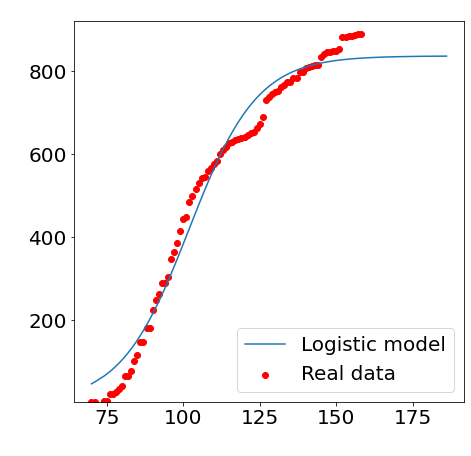

COVID is predicted to end in COTE D'IVOIRE 320 days after March 12, 2020


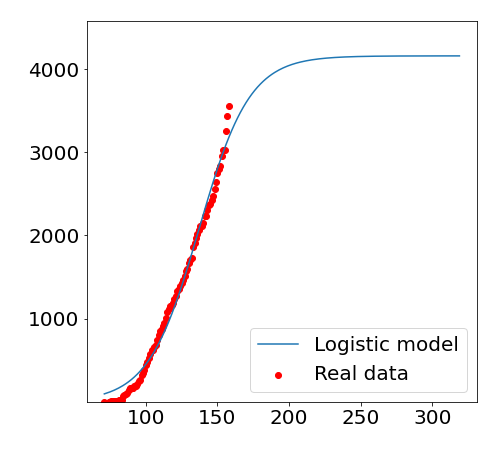

COVID is predicted to end in GABON 225 days after March 13, 2020


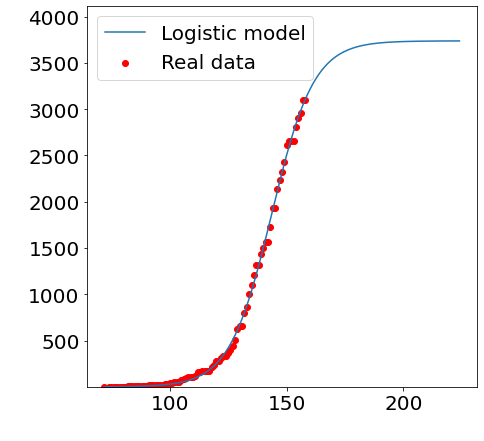

COVID is predicted to end in GHANA 232 days after March 13, 2020


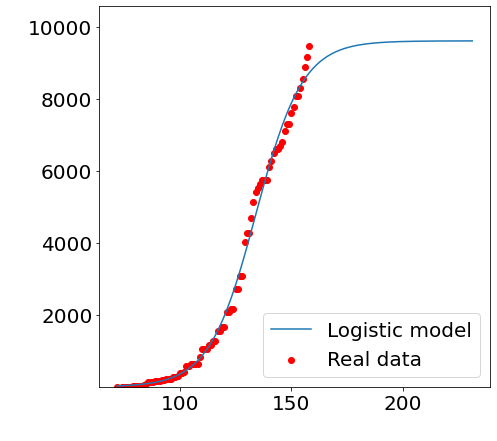


COVID is predicted to end in ETHIOPIA 232 days after March 14, 2020


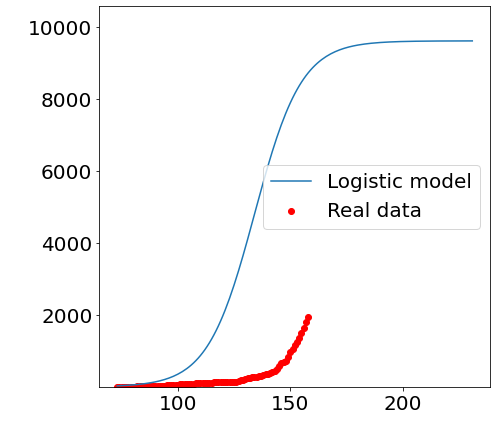

COVID is predicted to end in GUINEA 247 days after March 14, 2020


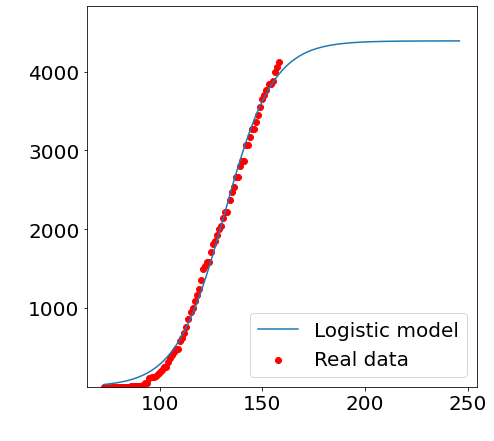


COVID is predicted to end in KENYA 247 days after March 14, 2020


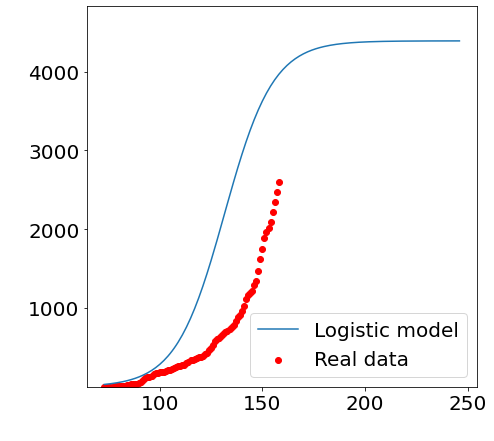

COVID is predicted to end in SUDAN 233 days after March 14, 2020


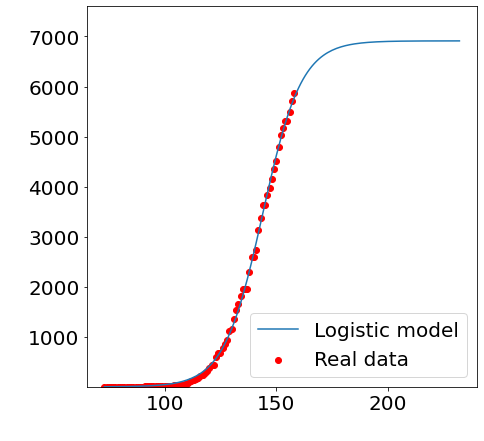

COVID is predicted to end in EQUATORIAL GUINEA 227 days after March 15, 2020


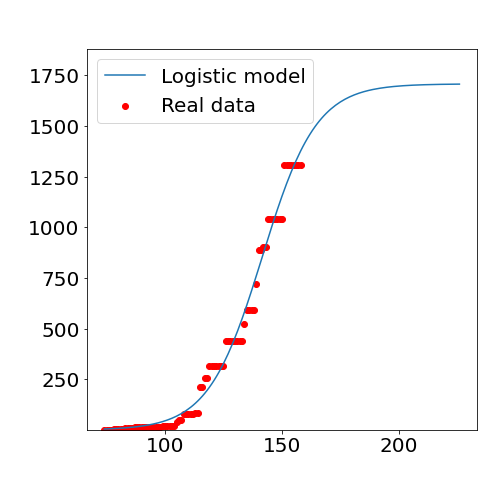

COVID is predicted to end in MAURITANIA 207 days after March 15, 2020


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp


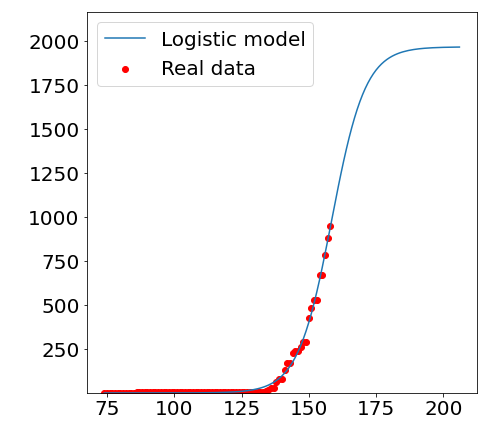

COVID is predicted to end in NAMIBIA 111 days after March 15, 2020


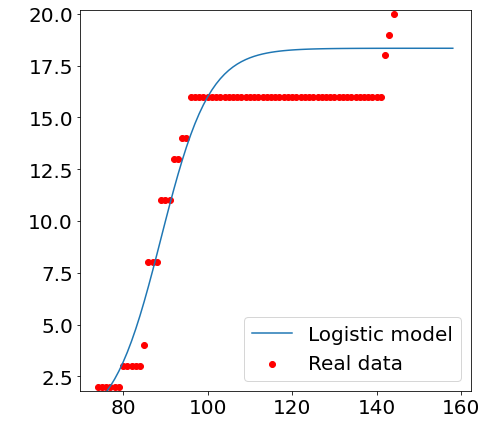

COVID is predicted to end in SEYCHELLES 159 days after March 15, 2020


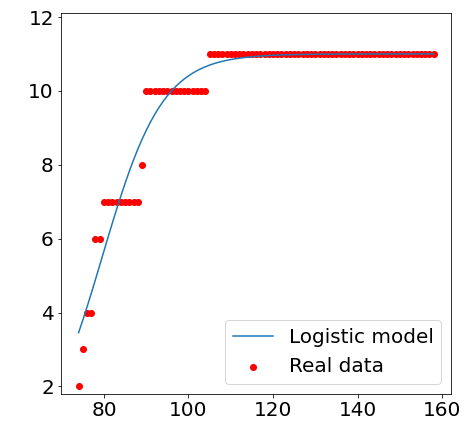

COVID is predicted to end in SWAZILAND 195 days after March 15, 2020


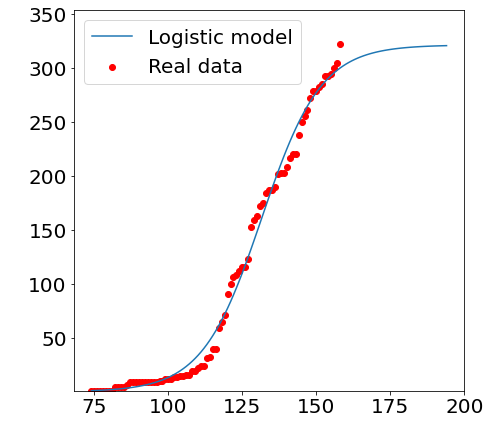

COVID is predicted to end in CENTRAL AFRICAN REPUBLIC 252 days after March 16, 2020


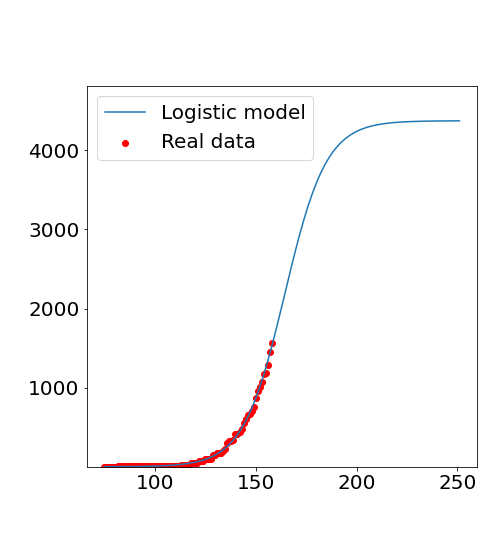

COVID is predicted to end in BENIN 145 days after March 17, 2020


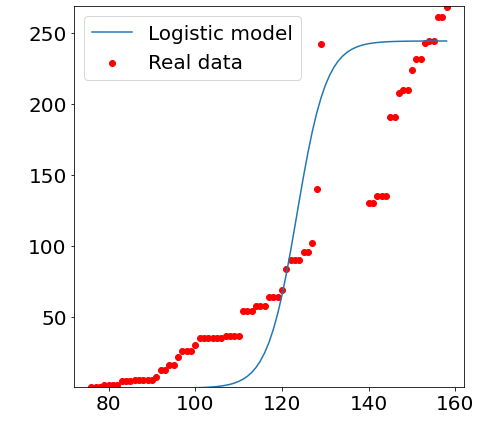

COVID is predicted to end in LIBERIA 208 days after March 17, 2020


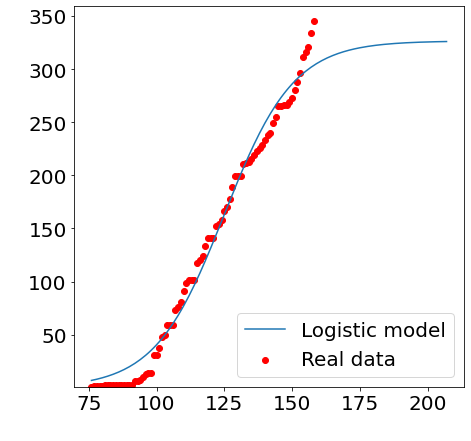

COVID is predicted to end in SOMALIA 223 days after March 17, 2020


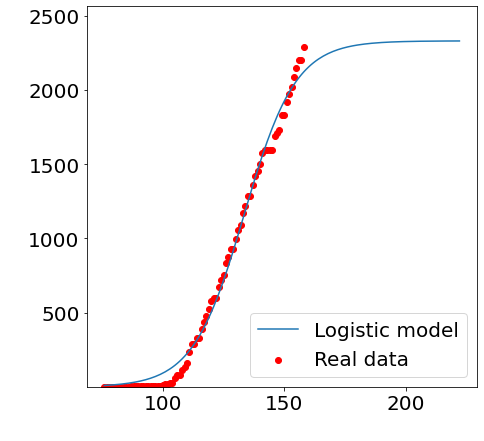

COVID is predicted to end in TANZANIA 145 days after March 17, 2020


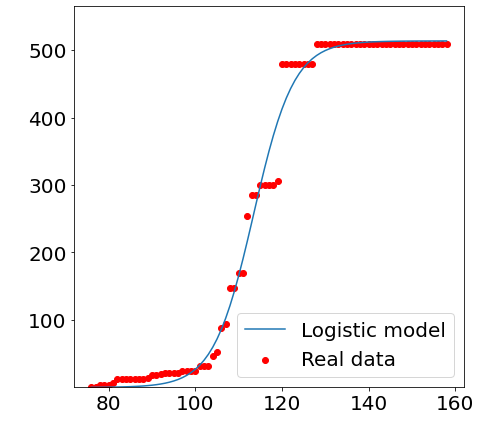

COVID is predicted to end in GAMBIA 171 days after March 18, 2020


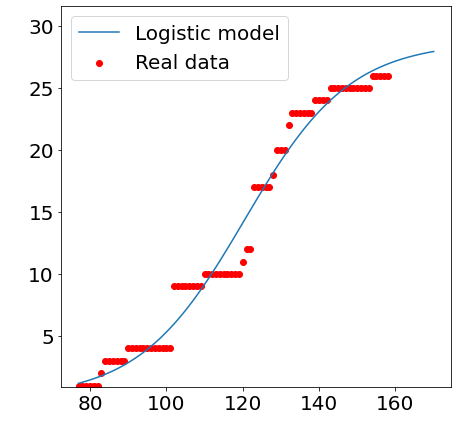


COVID is predicted to end in DJIBOUTI 171 days after March 19, 2020


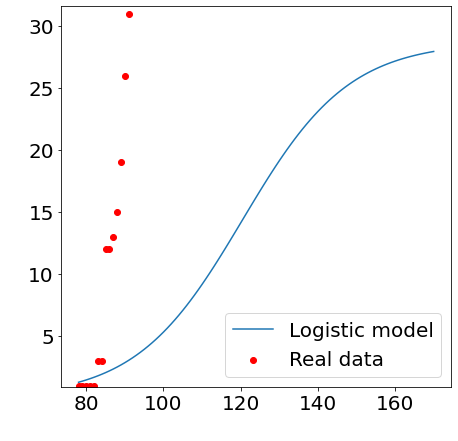

COVID is predicted to end in ZAMBIA 174 days after March 19, 2020


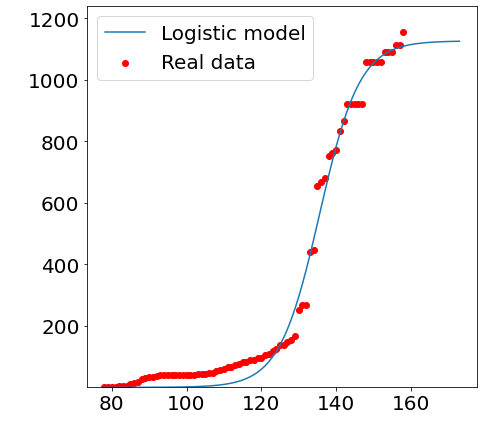

COVID is predicted to end in CHAD 186 days after March 20, 2020


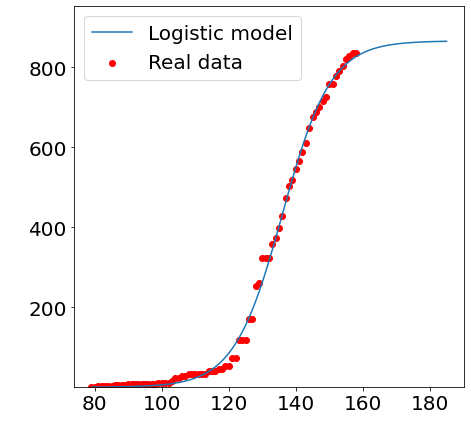

COVID is predicted to end in MAURITIUS 117 days after March 20, 2020


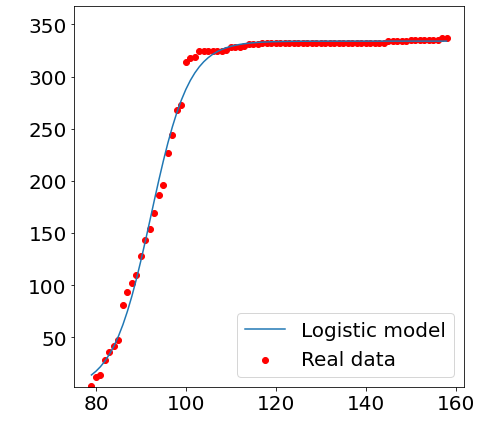

COVID is predicted to end in CAPE VERDE 206 days after March 21, 2020


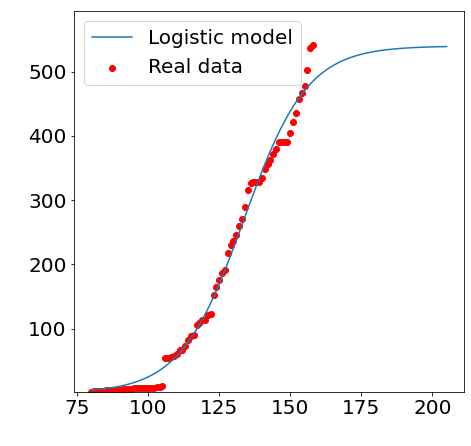


COVID is predicted to end in MADAGASCAR 206 days after March 21, 2020


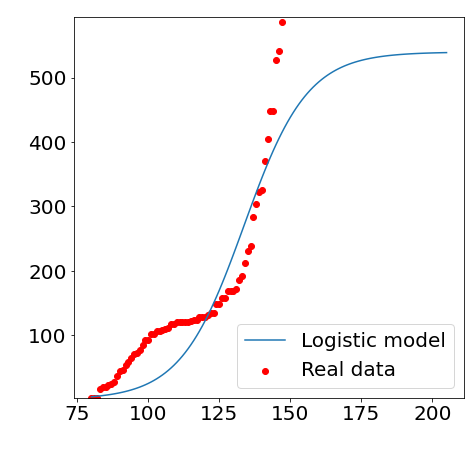

COVID is predicted to end in NIGER 156 days after March 21, 2020


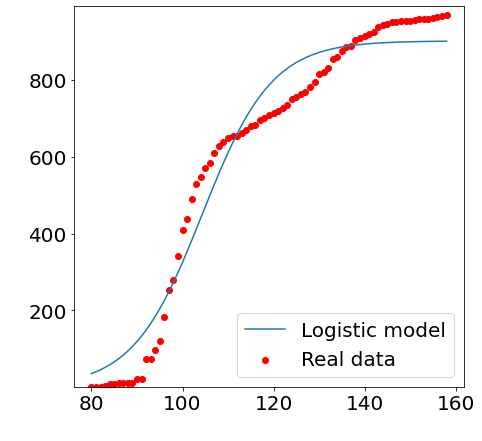


COVID is predicted to end in ZIMBABWE 156 days after March 21, 2020


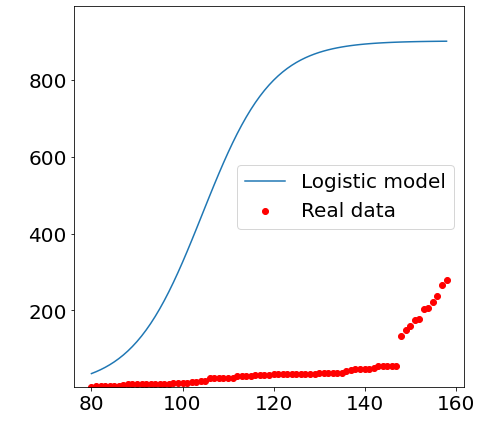

COVID is predicted to end in ANGOLA 302 days after March 22, 2020


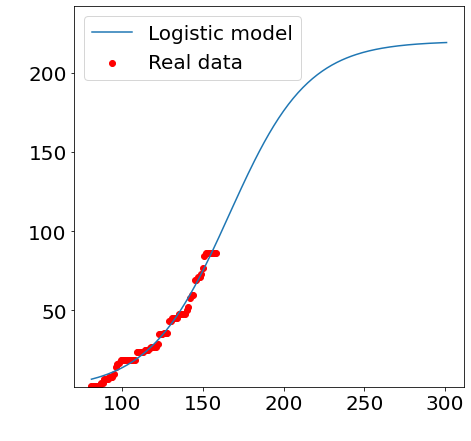

COVID is predicted to end in ERITREA 107 days after March 22, 2020


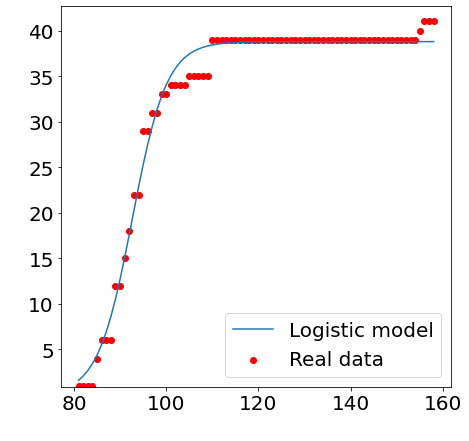


COVID is predicted to end in UGANDA 107 days after March 22, 2020


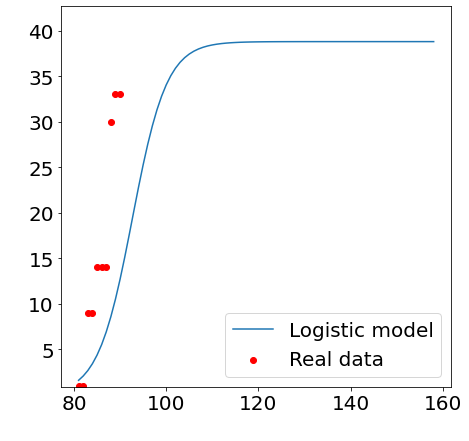


COVID is predicted to end in MOZAMBIQUE 107 days after March 23, 2020


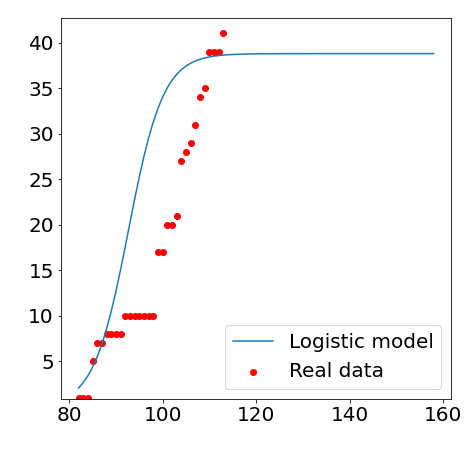


COVID is predicted to end in LIBYA 107 days after March 25, 2020


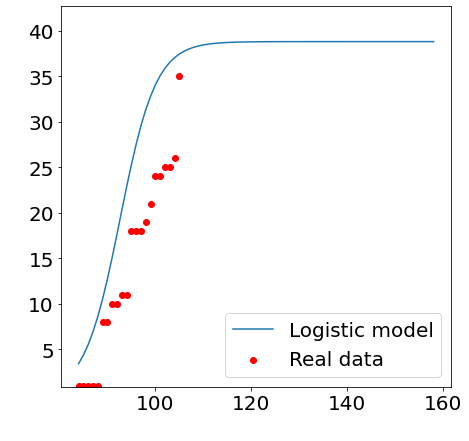

COVID is predicted to end in MALI 262 days after March 26, 2020


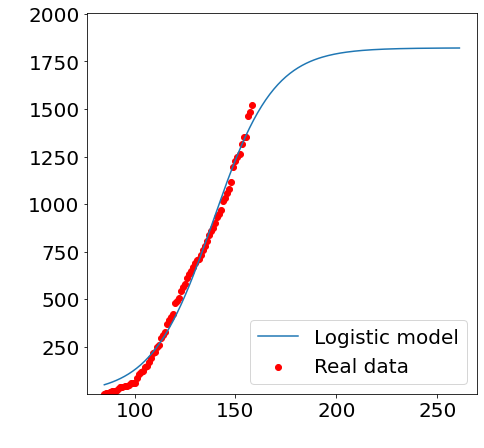

COVID is predicted to end in GUINEA-BISSAU 188 days after March 27, 2020


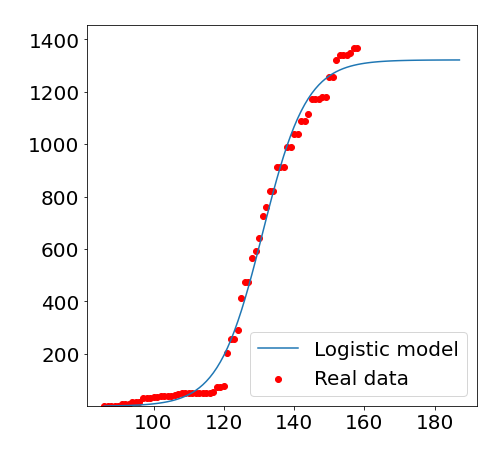

COVID is predicted to end in BOTSWANA 229 days after April 01, 2020


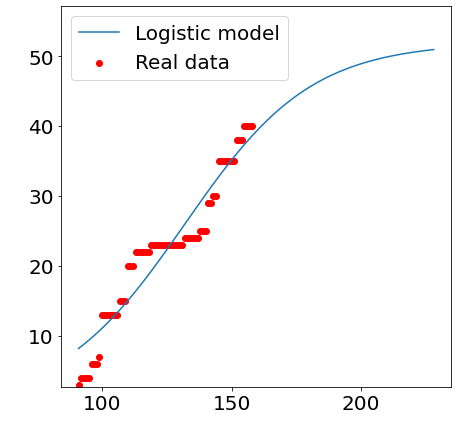

COVID is predicted to end in BURUNDI 320 days after April 01, 2020


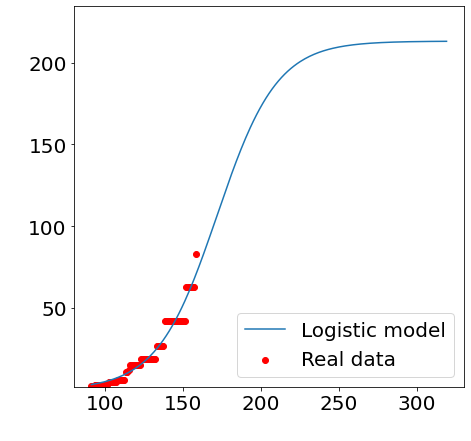

COVID is predicted to end in SIERRA LEONE 214 days after April 01, 2020


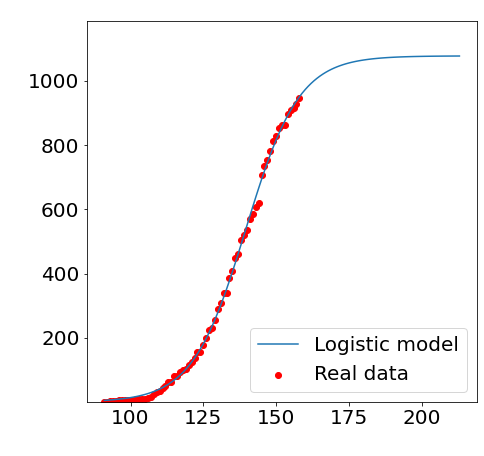


COVID is predicted to end in MALAWI 214 days after April 03, 2020


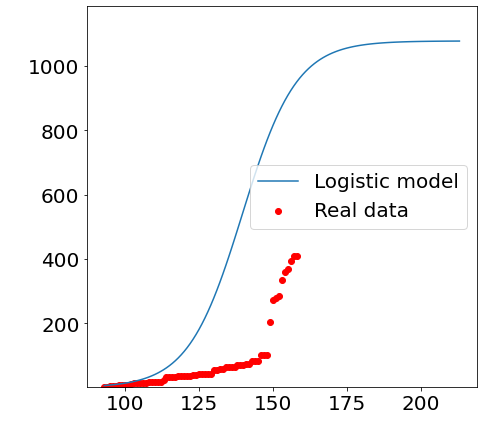

COVID is predicted to end in SOUTH SUDAN 206 days after April 06, 2020


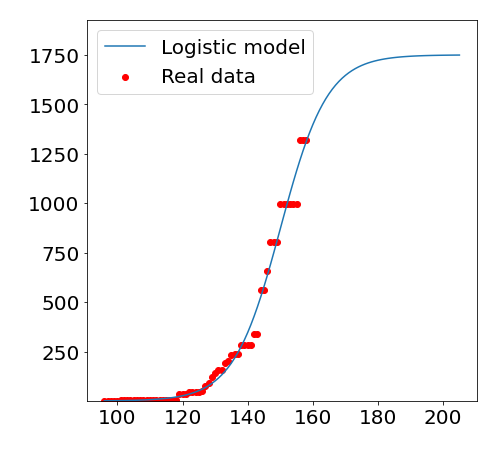

COVID is predicted to end in SAO TOME AND PRINCIPE 233 days after April 09, 2020


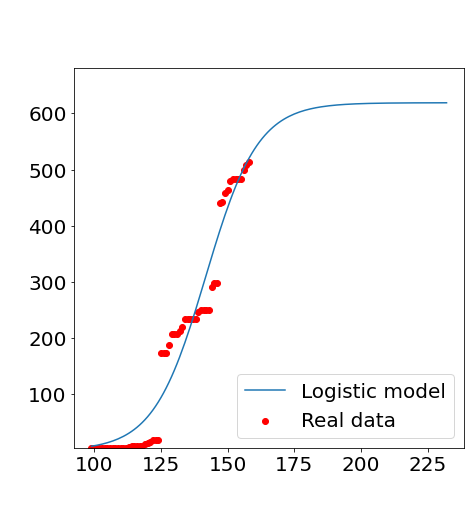


COVID is predicted to end in WESTERN SAHARA 233 days after April 26, 2020


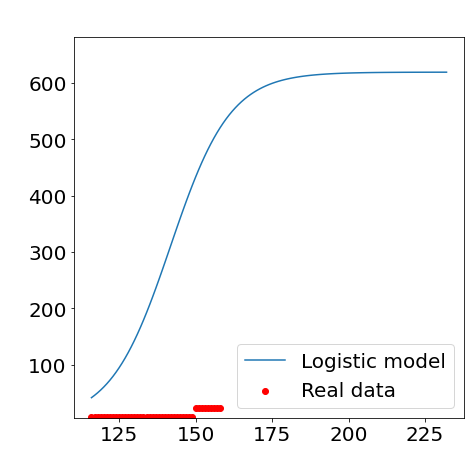

COVID is predicted to end in COMOROS 266 days after May 02, 2020


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


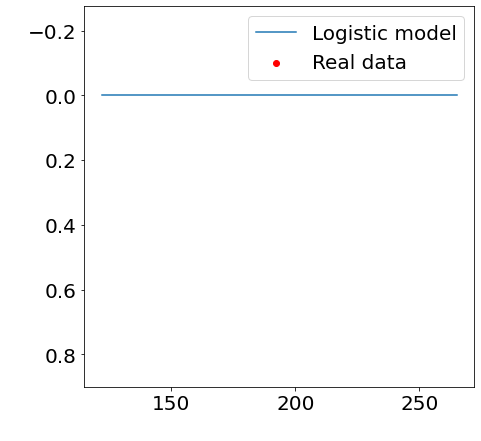

COVID is predicted to end in LESOTHO 42076 days after May 15, 2020


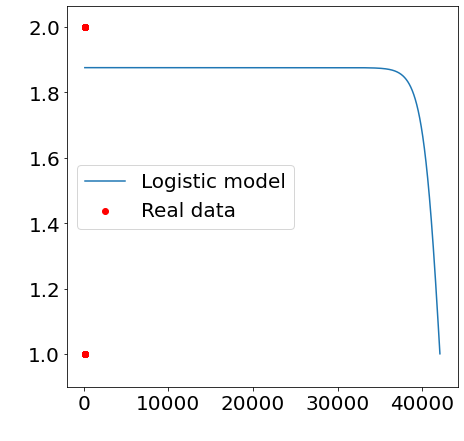

In [ ]:
#LOGISTIC CURVE FOR SPECIFIC AFRICAN COUNTRIES 
#sum number of cases in the countries by date
extrapolate_Africa_cases = pd.DataFrame(df_Africa_Logistic.groupby(['Date',"Entity"])["Total confirmed cases of COVID-19 (cases)"].sum()) #summed number of cases per day
extrapolate_Africa_cases = extrapolate_Africa_cases.add_suffix('Count').reset_index() #changed groupby to a dataframe
extrapolate_Africa_cases["Total confirmed cases of COVID-19 (cases)"] = extrapolate_Africa_cases.Date.dt.strftime('%Y-%m-%d %H:%M:%S')
extrapolate_Africa_cases.head()

FMT = '%Y-%m-%d %H:%M:%S'
extrapolate_Africa_cases['Date'].apply(lambda x: x.strftime('%Y-%m-%d')) #change date to string objects first
extrapolate_Africa_cases.rename(columns={"Total confirmed cases of COVID-19 (cases)Count": "cases",
                                              "Total confirmed cases of COVID-19 (cases)": "date_str"}, inplace=True) #rename needed column
date = extrapolate_Africa_cases["date_str"] #store dates column                                              
extrapolate_Africa_cases['date_str'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days)
extrapolate_Africa_cases = extrapolate_Africa_cases.drop(columns=['Date'])
extrapolate_Africa_cases.head()

ctry_list = list(extrapolate_Africa_cases["Entity"].unique())

#define the model
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a)) 
    
plt.figure(figsize=(5,5))

for i in ctry_list:
  df5 = extrapolate_Africa_cases.loc[extrapolate_Africa_cases["Entity"]==i]

  #estimate the parameter values and errors starting from the original data.
  x = list(df5.iloc[:,2])
  y = list(df5.iloc[:,1])
  try:
    fit = curve_fit(logistic_model,x,y,p0=[2,100,20000], method = "trf")
  except RuntimeError:
    print("")
  fit #gives values of a, b and c and the covariance matrix
  fit = list(fit)
  a = list(fit[0])[0]
  b = list(fit[0])[1]
  c = list(fit[0])[2]
  cov_matrix = list(fit[1])

  errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]] #gives standard error of a, b and c
  errors
  
  sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b)) #finding the day when infection will end 
  date = ""
  for j in firsts:
    if j[0] == i:
      date = j[1]
  print("COVID is predicted to end in "+ str.upper(i) + " " +
        str(sol) + " days after " + date.strftime('%B %d, %Y'))

  #4. Plot!
  font = {'family': 'serif',
        'color':  'white',
        'weight': 'normal',
        'size': 16}
  pred_x = list(range(max(x),sol))
  plt.rcParams['figure.figsize'] = [7,7]
  plt.rc('font', size=20)
  # Real data
  plt.scatter(x,y,label="Real data",color="red")
  # Predicted logistic curve
  plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], 
           label="Logistic model" )
  # Predicted exponential curve
  plt.legend()
  # print(str.upper(i))
  plt.xlabel("Days since 1 January 2020",fontdict=font)
  plt.ylabel("Total number of infected people ("  + str.upper(i) + ")",
             fontdict=font)
  plt.ylim(min(y)*0.9,fit[0][2]*1.1)
  plt.show()
  # input()

###Logistic Curve (Other Selected Countries)

In [ ]:
#lowercase of each country name:
a_list = ["italy", "united states","germany","spain","china","south korea","brazil","russia","united kingdom","armenia"]
a_list = [string.lower() for string in a_list]
a_indexlist = []
counter = 0
for i in df_World_Logistic['Entity']:
  if i in a_list:
      a_indexlist.append(counter)
  counter +=1
# print(italyindexlist)
#Extract those rows of the dataframe
df_Sample_Logistic = df_World_Logistic.loc[a_indexlist]
df_Sample_Logistic.head() #this is a seperate dataframe for only African countries, that we can use later on 

Entity Code       Date  Total confirmed cases of COVID-19 (cases)
966  armenia  arm 2019-12-31                                          0
967  armenia  arm 2020-01-01                                          0
968  armenia  arm 2020-01-02                                          0
969  armenia  arm 2020-01-03                                          0
970  armenia  arm 2020-01-04                                          0

In [ ]:
#findings first day that first case was recorded
#first make a list:
firsts = []
countries = []
df_Sample_Logistic.head(60)
df1 = df_Sample_Logistic.loc[df_Sample_Logistic['Total confirmed cases of COVID-19 (cases)']==1]
df1.head()
len(df1["Entity"].unique())

for index in df1.index:
    if df1["Entity"][index] not in countries:
      countries.append(df1["Entity"][index])
      if df1['Total confirmed cases of COVID-19 (cases)'][index] == 1:
        firsts.append([df1["Entity"][index],df1["Date"][index]])
print(firsts)

[['armenia', Timestamp('2020-03-01 00:00:00')], ['brazil', Timestamp('2020-02-26 00:00:00')], ['germany', Timestamp('2020-01-28 00:00:00')], ['south korea', Timestamp('2020-01-20 00:00:00')], ['spain', Timestamp('2020-02-01 00:00:00')], ['united states', Timestamp('2020-01-21 00:00:00')]]


In [ ]:
#now extract for rest of countries you have not extracted for
countries_left=[]
for i in df_Sample_Logistic["Entity"].unique():
  if i not in [j[0] for j in firsts]:
    countries_left.append(i)

df2 = pd.DataFrame()
indexlist =[]

for index in df_Sample_Logistic.index:
    if df_Sample_Logistic["Entity"][index] in countries_left:
      indexlist.append(index)

df2 = df_Sample_Logistic.loc[indexlist]

df2.head()
df3 = pd.DataFrame()
templist = []
indexlist=[]
gameover = False

df2["Entity"].unique()

for i in countries_left:
  templist.append(i)
  # print(templist)
  # input()
  for index in df2.index:
     if df2["Entity"][index] in templist:
       indexlist.append(index)
    #  print(indexlist)
     df3 = df2.loc[indexlist]
  for index in df3.index:
    if gameover == False:
      firsts.append([df3["Entity"][index],df3["Date"][index]])
      gameover = True
  templist=[]
  indexlist=[]
  df3 = pd.DataFrame()
  gameover = False
len(firsts)

10


COVID is predicted to end in ARMENIA 42076 days after March 01, 2020


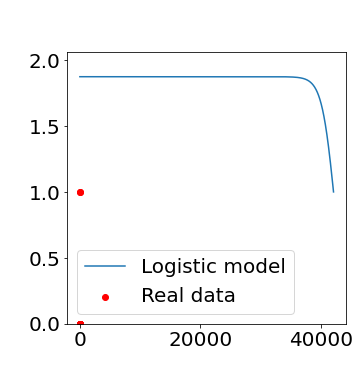

COVID is predicted to end in BRAZIL 366 days after February 26, 2020


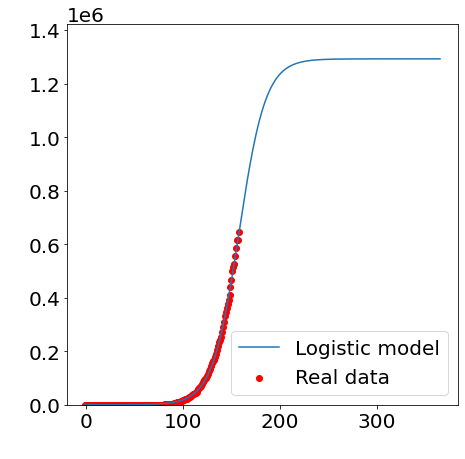

COVID is predicted to end in CHINA 95 days after December 31, 2019


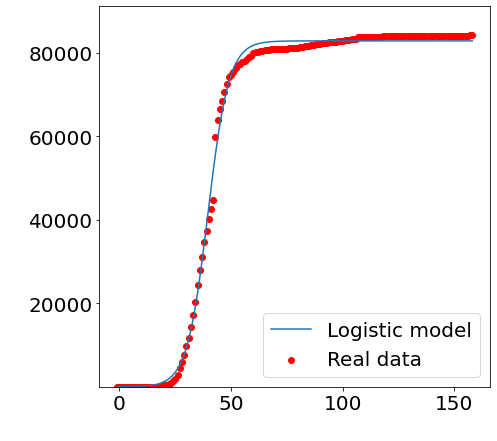

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp



COVID is predicted to end in GERMANY 95 days after January 28, 2020


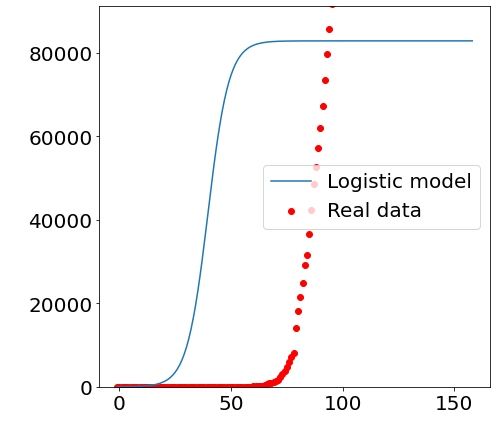

COVID is predicted to end in ITALY 227 days after December 31, 2019


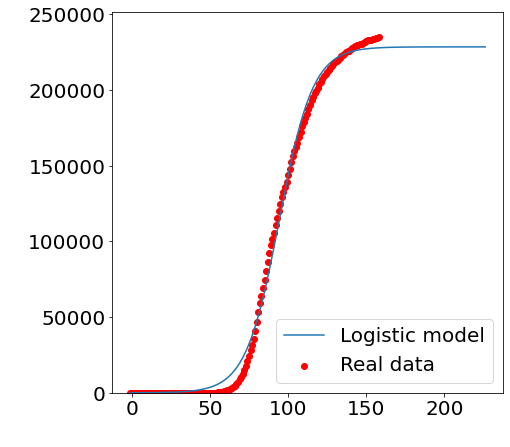

COVID is predicted to end in RUSSIA 278 days after December 31, 2019


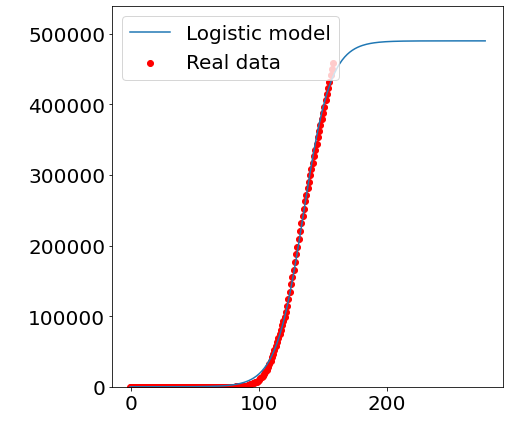

COVID is predicted to end in SOUTH KOREA 131 days after January 20, 2020


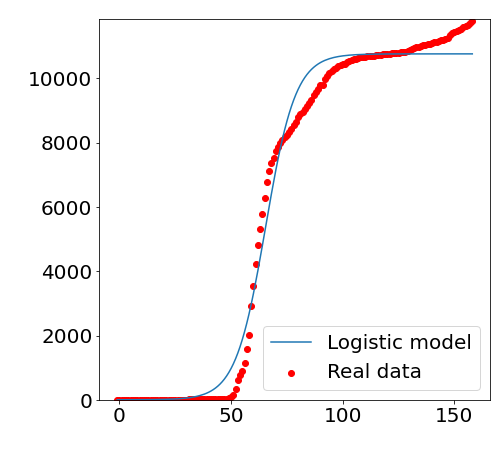

COVID is predicted to end in SPAIN 193 days after February 01, 2020


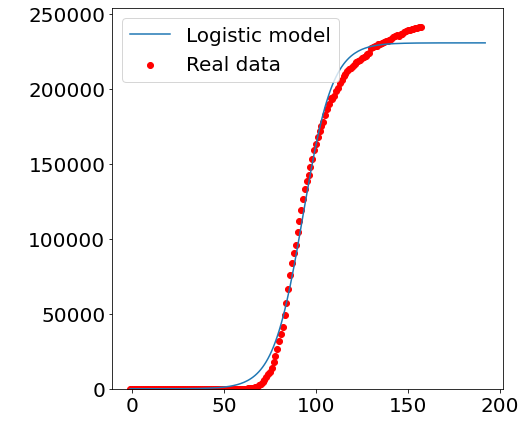

COVID is predicted to end in UNITED KINGDOM 275 days after December 31, 2019


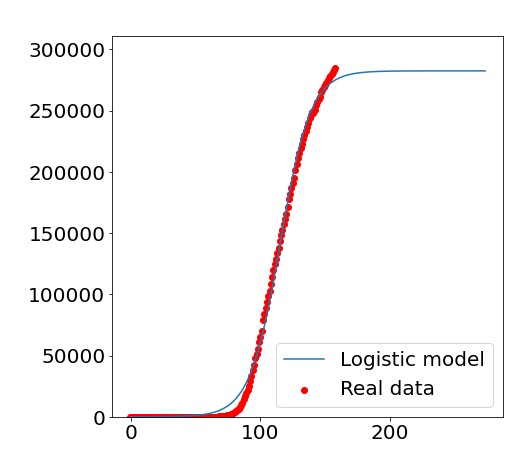

COVID is predicted to end in UNITED STATES 340 days after January 21, 2020


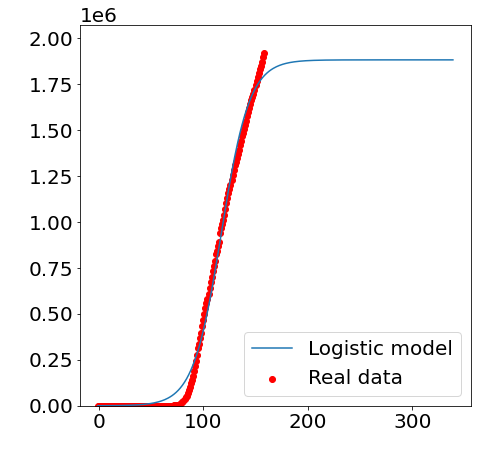

In [ ]:
#sum number of cases in the countries by date
extrapolate_Sample_cases = pd.DataFrame(df_Sample_Logistic.groupby(['Date',"Entity"])["Total confirmed cases of COVID-19 (cases)"].sum()) #summed number of cases per day
extrapolate_Sample_cases = extrapolate_Sample_cases.add_suffix('Count').reset_index() #changed groupby to a dataframe
extrapolate_Sample_cases["Total confirmed cases of COVID-19 (cases)"] = extrapolate_Sample_cases.Date.dt.strftime('%Y-%m-%d %H:%M:%S')
extrapolate_Sample_cases.head()

FMT = '%Y-%m-%d %H:%M:%S'
extrapolate_Sample_cases['Date'].apply(lambda x: x.strftime('%Y-%m-%d')) #change date to string objects first
extrapolate_Sample_cases.rename(columns={"Total confirmed cases of COVID-19 (cases)Count": "cases",
                                              "Total confirmed cases of COVID-19 (cases)": "date_str"}, inplace=True) #rename needed column
date = extrapolate_Sample_cases["date_str"] #store dates column                                              
extrapolate_Sample_cases['date_str'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days)
extrapolate_Sample_cases = extrapolate_Sample_cases.drop(columns=['Date'])
extrapolate_Sample_cases.head()

ctry_list = list(extrapolate_Sample_cases["Entity"].unique())

#define the model
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a)) 
    
plt.figure(figsize=(5,5))

for i in ctry_list:
  df5 = extrapolate_Sample_cases.loc[extrapolate_Sample_cases["Entity"]==i]

  #estimate the parameter values and errors starting from the original data.
  x = list(df5.iloc[:,2])
  y = list(df5.iloc[:,1])
  try:
    fit = curve_fit(logistic_model,x,y,p0=[2,100,20000], method = "trf")
  except RuntimeError:
    print("")
  fit #gives values of a, b and c and the covariance matrix
  fit = list(fit)
  a = list(fit[0])[0]
  b = list(fit[0])[1]
  c = list(fit[0])[2]
  cov_matrix = list(fit[1])

  errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]] #gives standard error of a, b and c
  errors
  
  sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b)) #finding the day when infection will end 
  date = ""
  for j in firsts:
    if j[0] == i:
      date = j[1]
  print("COVID is predicted to end in "+ str.upper(i) + " " +
        str(sol) + " days after " + date.strftime('%B %d, %Y'))

  #4. Plot!
  font = {'family': 'serif',
        'color':  'white',
        'weight': 'normal',
        'size': 16}
  pred_x = list(range(max(x),sol))
  plt.rcParams['figure.figsize'] = [7,7]
  plt.rc('font', size=20)
  # Real data
  plt.scatter(x,y,label="Real data",color="red")
  # Predicted logistic curve
  plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], 
           label="Logistic model" )
  # Predicted exponential curve
  plt.legend()
  # print(str.upper(i))
  plt.xlabel("Days since 1 January 2020",fontdict=font)
  plt.ylabel("Total number of infected people ("  + str.upper(i) + ")",
             fontdict=font)
  plt.ylim(min(y)*0.9,fit[0][2]*1.1)
  plt.show()
  # input()

#Using Neural Networks to develop trends 
*Might want to get dataset with more rows for this one*

*Activities and tools used:*

*Findings:*

###Preparing Dataset(s)

In [ ]:
#function for dropping rows:
def droprows(droplist,templist,dataframe,column_name):
  for i in droplist:
    alist = dataframe[dataframe[column_name]==i].index.values
    for j in alist:
      templist.append(j)
      alist = []
  return templist

In [ ]:
#prepare dataframe
df_World_Logistic
df_World_NN = df_World_Logistic.copy()
df_World_NN["Entity"].unique()

#drop all rows with african countries
drop = ['africa', 'asia excl. china', 'europe','european union','high income','international','low income', 
            'lower middle income','oceania','upper middle income','world', 'world excl. china', 
            'world excl. china and south korea','world excl. china, south korea, japan and singapore',
            'north america','south america']
temp = []
temp = droprows(drop,temp,df_World_NN,"Entity")
temp

#extract those rows into a new dataframe before dropping then:
df = df_World_NN.loc[templist]
df_World_NN = df_World_NN.drop(templist)
df_World_NN["Entity"].unique()

#group by dates
df_World_NN_group = df_World_NN.groupby(['Date']).sum()
df_World_NN = df_World_NN_group.reset_index()
df_World_NN.head() #dataframe ready now! (univariate data)

Date  Total confirmed cases of COVID-19 (cases)
0 2019-12-31                                        108
1 2020-01-01                                        108
2 2020-01-02                                        108
3 2020-01-03                                        176
4 2020-01-04                                        176

###Training and Visualisations

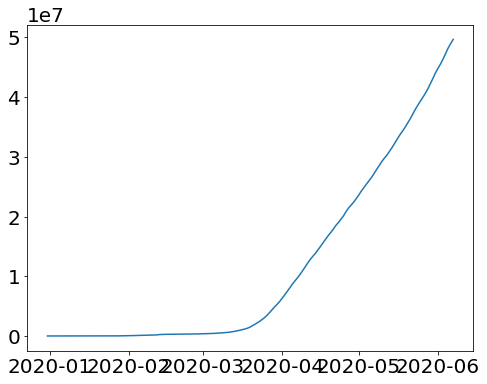

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

#visual representation
plt.plot(df_World_NN['Date'], df_World_NN["Total confirmed cases of COVID-19 (cases)"])

In [ ]:
# The function below returns the above described windows of time for the model to train on. 
# The parameter history_size is the size of the past window of information. The target_size 
# is how far in the future does the model need to learn to predict. The target_size is the 
# label that needs to be predicted.

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

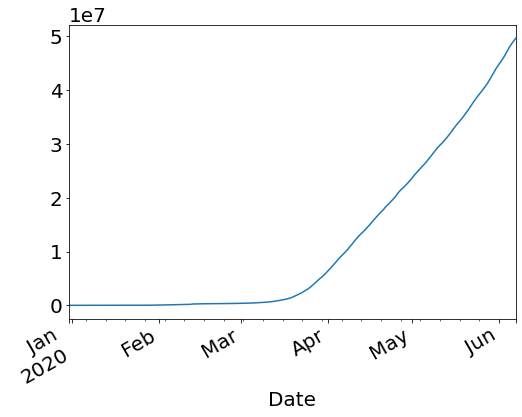

In [ ]:
TRAIN_SPLIT = 120
tf.random.set_seed(3)

# Forecast a univariate time series
# First, you will train a model using only a single feature (temperature), and use 
# it to make predictions for that value in the future
# Let's first extract only the temperature from the dataset.
uni_data = df_World_NN['Total confirmed cases of COVID-19 (cases)']
uni_data.index = df_World_NN['Date']
uni_data.head()

#Let's observe how this data looks across time
uni_data.plot(subplots=True)

uni_data = uni_data.values

#It is important to scale features before training a neural network. Standardization 
#is a common way of doing this scaling by subtracting the mean and dividing by the 
#standard deviation of each feature.You could also use a tf.keras.utils.normalize 
#method that rescales the values into a range of [0,1].
#Note: The mean and standard deviation should only be computed using the training data.
#this actually might not make sense for the kind of data I have. Maybe?
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_train_mean, uni_train_std

#standardize data:
uni_data = (uni_data-uni_train_mean)/uni_train_std
# uni_data

In [ ]:
#Let's now create the data for the univariate model. The model will 
# be given the last xx recorded cases, and needs to learn to 
# predict the cases at the next time step.
univariate_past_history = 6
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [ ]:
#output form univariate function
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target case predict')
print (y_train_uni[0])

Single window of past history
[[-0.61252128]
 [-0.61252128]
 [-0.61252128]
 [-0.61251035]
 [-0.61251035]
 [-0.6125007 ]]

 Target case predict
-0.6125006966227959


In [ ]:
#Now that the data has been created, let's take a look at a single example. 
#The information given to the network is given in blue, and it must predict the 
#value at the red cross.
def create_time_steps(length):
  return list(range(-length, 0))

#function for plot
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

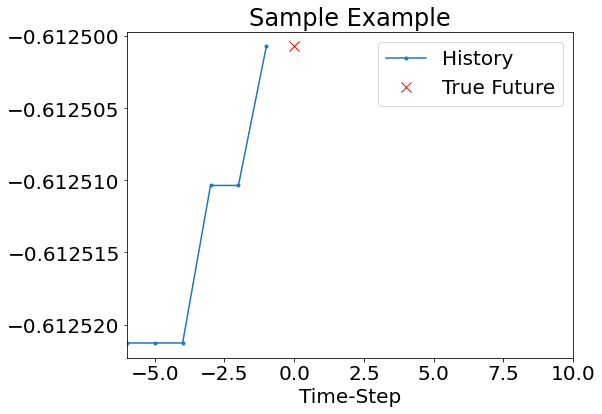

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [ ]:
# Baseline
# Before proceeding to train a model, let's first set a simple baseline. Given an 
# input point, the baseline method looks at all the history and predicts the next 
# point to be the average of the last 20 observations

def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

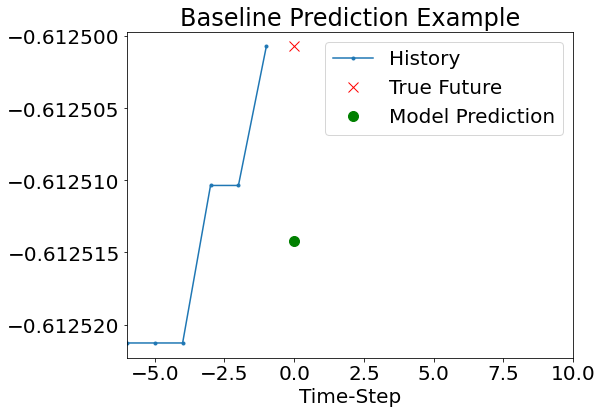

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

# Let's see if you can beat this baseline using a recurrent neural network.

###Recurrent neural network
A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the RNN tutorial. In this tutorial, you will use a specialized RNN layer called Long Short Term Memory (LSTM)

Let's now use tf.data to shuffle, batch, and cache the dataset.

(34, 1)
Epoch 1/5
10000/10000 [==============================] - 34s 3ms/step - loss: 0.0160 - val_loss: 1.7196
Epoch 2/5
10000/10000 [==============================] - 34s 3ms/step - loss: 0.0034 - val_loss: 1.5741
Epoch 3/5
10000/10000 [==============================] - 35s 3ms/step - loss: 0.0031 - val_loss: 1.5081
Epoch 4/5
10000/10000 [==============================] - 34s 3ms/step - loss: 0.0030 - val_loss: 1.4478
Epoch 5/5
10000/10000 [==============================] - 34s 3ms/step - loss: 0.0027 - val_loss: 1.3889


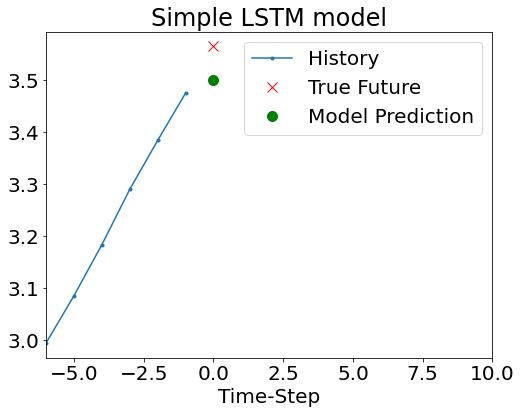

In [ ]:
BATCH_SIZE = 115
BUFFER_SIZE = 100

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

#You will see the LSTM requires the input shape of the data it is being given
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

#Let's make a sample prediction, to check the output of the model.
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

#Let's train the model now. In the interest of saving time, each epoch will only 
#run for xx steps, instead of the complete training data as normally done.
EVALUATION_INTERVAL = 10000
EPOCHS = 5

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

# Predict using the simple LSTM model
# Now that you have trained your simple LSTM, let's try and make a few predictions.
for x, y in val_univariate.take(1):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

#Graphing an SIRD Model using the data available 


*Activities and tools used:*

*Findings:*

1. Susceptible Pop column = "population" column - everything else 
2. Infected Pop column = "total_cases" column - Recovered column
3. Recovered Pop column = the value of "total_cases" three weeks ago 
4. Dead Population column = "total_deaths" column 





###Preparing Dataset(s)

In [ ]:
df_World_SIRD = pd.read_csv("owid-covid-data.csv")
#lower case all
df_World_SIRD = df_World_SIRD.apply(lambda x: x.astype(str).str.lower() if(x.dtype == 'object') else x)
#convert to date time object
df_World_SIRD["date"] = pd.to_datetime(df_World_SIRD["date"])
df_World_SIRD.tail()

iso_code continent  ... hospital_beds_per_thousand life_expectancy
27595      nan       nan  ...                        NaN             NaN
27596      nan       nan  ...                        NaN             NaN
27597      nan       nan  ...                        NaN             NaN
27598      nan       nan  ...                        NaN             NaN
27599      nan       nan  ...                        NaN             NaN

[5 rows x 34 columns]

In [ ]:
#Missing data? duplications? what countries?
print("Number of duplications:", df_World_SIRD.duplicated().sum()) #no duplications
(df_World_SIRD.isnull().sum()/df_World_SIRD.shape[0])*100 #some missing data

Number of duplications: 0


iso_code                            0.000000
continent                           0.000000
location                            0.000000
date                                0.000000
total_cases                         0.811594
new_cases                           0.811594
total_deaths                        0.811594
new_deaths                          0.811594
total_cases_per_million             1.043478
new_cases_per_million               1.043478
total_deaths_per_million            1.043478
new_deaths_per_million              1.043478
total_tests                        70.550725
new_tests                          72.166667
total_tests_per_thousand           70.550725
new_tests_per_thousand             72.166667
new_tests_smoothed                 68.442029
new_tests_smoothed_per_thousand    68.442029
tests_units                         0.000000
stringency_index                   19.887681
population                          0.231884
population_density                  4.380435
median_age

## Function for SIRD Model

In [ ]:
#a function that does the whole SIR model
def SIRD_Model(df,country_name):
  #create copy of original dataframe:
  df_temp = df.copy()

  #extract country's dataframe:
  #lowercase of each country name:
  ctry_name = [country_name]
  print(ctry_name)
  ctry_indexlist = []
  counter = 0
  for i in df_temp['location']:
    if i in ctry_name:
        ctry_indexlist.append(counter)
    counter +=1
  #Extract those rows of the dataframe
  df_ctry = df_temp.loc[ctry_indexlist]
  df_ctry.head() 

  #prepare S,I,R and D columns for the original dataframe:
  #first create recovered columns with appropriate dates and merge to original dataframe
  df_temp2 = df_ctry[['date', 'total_cases']].copy()
  df_temp2["three_weeks_later"] = df_temp2["date"] + datetime.timedelta(days=21)
  df_temp2.rename({'total_cases': 'Recovered'}, axis=1, inplace=True)
  df_temp2 = df_temp2.drop(columns=['date'])
  df_temp2.head()
  df_ctry = df_ctry.merge(df_temp2, left_on='date', right_on='three_weeks_later')
  df_ctry.head()
  #now create suscpetible, infected, recovered and dead columns
  df_ctry["Dead"] = df_ctry["total_deaths"]
  df_ctry["Recovered"] = df_ctry["Recovered"] - df_ctry["Dead"]
  df_ctry["Infected"] = df_ctry["total_cases"] - df_ctry["Recovered"] 
  df_ctry["Susceptible"] = df_ctry["population"] - df_ctry["Infected"] - df_ctry["Recovered"] - df_ctry["Dead"]
  df_ctry["Checking"] = df_ctry["Susceptible"] + df_ctry["Infected"] + df_ctry["Recovered"] + df_ctry["Dead"]
  df_ctry.head()
  #check if correct by preparing a column that adds all these columns 
  print(df_ctry["Checking"].unique()) #worked!

  #do needed graphs:
  df_ctry.plot(x="date", y=["Infected",
                              "Recovered","Dead"])
  plt.legend()
  plt.xlabel("Day")
  plt.ylabel("Population")
  plt.rcParams["figure.figsize"] = [10,10]
  plt.show()

  df_ctry.plot(x="date", y=["Susceptible"])
  plt.legend()
  plt.xlabel("Day")
  plt.ylabel("Population")
  plt.rcParams["figure.figsize"] = [10,10]
  plt.show()

  #return original dataframe to its normal state
  df_temp = pd.DataFrame()


## Visualizations for Selected Countries

['ghana']
[31072945.]


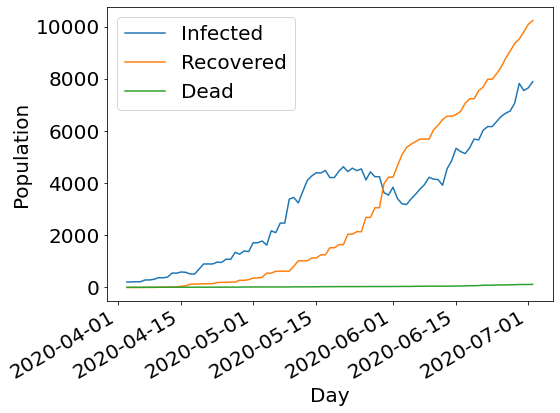

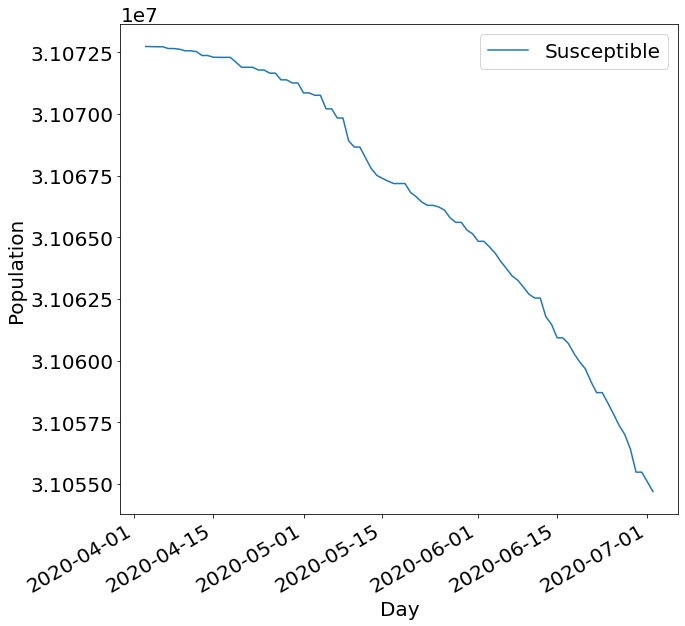

In [ ]:
#main SIR Model :)
import datetime
from datetime import timedelta

SIRD_Model(df_World_SIRD,"ghana") #do for african countries only and see whats going on

In [ ]:
# df_World_SIRD["location"].unique()

#Using NLTK to predict whether a COVID patient will eventually die or survive the pandemic (`outcome` and selected columns)


*Activities and tools used:*

*Findings:*


*`symptoms`, `travel_history_location`, `reported_market_exposure`,`additional_information`, `chronic_disease_binary`, `chronic_disease`,`location`,`travel_history_binary` columns

+ now expand nltk to also consider multiple columns stated above instead of just 1

###General NLTK Function

*later come and make nltk function stronger?? find out online how to do this

In [ ]:
#whole nltk function
def nltk_func(target, feature, Yes, No):
    #check class distribution
    classes = target
    classes.value_counts() #more alive than approaching death therefore skewed class distribution
    #convert class labels to binary values #1 =  dead, 0 = alive
    encoder = LabelEncoder()
    Y = encoder.fit_transform(classes)
    classes[:10]
    #store the additional info data 
    additional_info = feature
    #remove punctuation
    processed = additional_info.str.replace(r"[^\w\d\s]"," ")
    #replace whitespace between terms with a single space
    processed = processed.str.replace(r"r'\s+", " ")
    #remove leading training whitespaces
    processed = processed.str.replace(r"^\s+|\s+?$","")
    #change words to loer case - Hello, HELLO, hello are all the same word!
    processed = processed.str.lower()
    #replace normal numbers with "numbr"
    processed = processed.str.replace(r"\d+(\.\d+)?","numbr")
    #remove stop words from additional info
    stop_words = set(stopwords.words("english"))
    processed = processed.apply(lambda x: " ".join(term for term in x.split() if term not in stop_words))
    #remove word stems using a Porter stemmer e.g. ing and ed for tenses, "i have"
    ps = nltk.PorterStemmer()
    processed = processed.apply(lambda x:" ".join(ps.stem(term) for term in x.split()))
    #creating a bag-of-words
    all_words =[]
    for message in processed:
      words = word_tokenize(message)
      for w in words:
        all_words.append(w)
    all_words = nltk.FreqDist(all_words)
    all_words
    #print the total number of words and the 5 most common words
    print("Number of words:{}".format(len(all_words)))
    print("Most common words: {}".format(all_words.most_common(5)))
    #use the 1500 most common words as features
    word_features = list(all_words.keys())[:]
    #define a find_features function
    def find_features(message):
      words = word_tokenize(message)
      features = {} #dictionary
      for word in word_features: #looping through the list 200 most common words
        features[word] = (word in words) 
      return features
    #find features for all messages
    messages = list(zip(processed, Y))
    #define a seed for reproducibility
    seed = 1
    np.random.seed = seed
    np.random.shuffle(messages) #shuffling text msgs just in case spam are at one place
    #call find_features function for each SMS messages
    featuresets = [(find_features(text), label) for (text,label) in messages]
    #split training and test data sets using sklearn
    # print(featuresets)
    # print(type(featuresets))
    training, testing = model_selection.train_test_split(featuresets, test_size = 0.25, 
                                                        random_state=seed, shuffle = True)
    # print("here")
    print("Training: {}".format(len(training)))
    print("Testing: {}".format(len(testing)))
    # print(testing)
    #Define models to train
    names = ["K Nearest Neighbors", "Decision Tree", "Random Forest",
            "Logistic Regression", "SGD Classifier", "Naive Bayes", "SVN Linear"]
    classifiers = [ KNeighborsClassifier(), DecisionTreeClassifier(),
                  RandomForestClassifier(), LogisticRegression(),
                  SGDClassifier(max_iter=100),MultinomialNB(), SVC(kernel = "linear")
                  ]
    models = list(zip(names, classifiers))
    # print(models) #to see parameters each model is using

    #wrap models in nltk 
    #train a lot of models and print accuracy etc for each one
    #more like a grid search?
    for name, model in models:
      nltk_model = SklearnClassifier(model)
      nltk_model.train(training)
      accuracy = nltk.classify.accuracy(nltk_model,testing)*100
      print('{}: Accuracy: {}'.format(name,accuracy))
    #build an ensemble method - Voting classifier where we combine all the algorithms
    #we have trained to make decisions
    names = ["K Nearest Neighbors", "Decision Tree", "Random Forest",
            "Logistic Regression", "SGD Classifier", "Naive Bayes", "SVC Linear"]
    classifiers = [ KNeighborsClassifier(), DecisionTreeClassifier(),
                  RandomForestClassifier(), LogisticRegression(),
                  SGDClassifier(max_iter=100),MultinomialNB(), SVC(kernel = "linear")
                  ]
    models = list(zip(names, classifiers))
    nltk_ensemble = SklearnClassifier(VotingClassifier(estimators=models,voting ="hard", n_jobs=-1))
    #with hard voting, binary response. With soft voting, you get a prob that it belongs to a particular class
    nltk_ensemble.train(training)
    accuracy = nltk.classify.accuracy(nltk_ensemble,testing)*100
    print()
    print('Ensemble Method Accuracy: {}'.format(accuracy)) 
    #the accuracy is much higher than for most other the individual models
    #make class label predictions for testing set
    txt_features, labels = zip(*testing)
    prediction = nltk_ensemble.classify_many(txt_features)
    #print a confusion matrix and a classification report
    print(classification_report(labels, prediction))
    print("CONFUSION MATRIX:")
    print(pd.DataFrame(confusion_matrix(labels, prediction), 
                index=[["actual", "actual"],[Yes,No]],
                columns = [["predicted", "predicted"],[Yes, No]]))
    return 

In [ ]:
#change to read "latestdata" from the indicators folder
df_World_Mega = pd.read_csv("latestdata.csv")
df_World_Mega = df_World_Mega.apply(lambda x: x.astype(str).str.lower() if(x.dtype == 'object') else x)

#solved the nan issue here
dflist = [df_World_Mega]
for df_old in dflist:
  df_old.replace({"nan":np.nan}, inplace=True)

#drop duplicated data from dataframe
print(df_World_Mega.duplicated().sum())
df_World_Mega = df_World_Mega.drop_duplicates(keep = 'first')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,9,10,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,28,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0


## Preparing Dataset(s)

In [ ]:
WA_list = ["Algeria","Angola","Benin","Botswana","Burkina Faso","Burundi","Cameroon","Cape Verde",
           "Central African Republic","Chad","Comoros","Congo-Brazzaville","Congo-Kinshasa","Cote d'Ivoire",
           "Djibouti","Egypt","Equatorial Guinea","Eritrea","Ethiopia","Gabon","Gambia","Ghana",
           "Guinea","Guinea Bissau","Kenya","Lesotho","Liberia","Libya","Madagascar","Malawi",
           "Mali","Mauritania","Mauritius","Morocco","Mozambique","Namibia","Niger","Nigeria","Rwanda"
           "Senegal","Seychelles","Sierra Leone","Somalia","South Africa","South Sudan","Sudan","Swaziland",
           "São Tomé and Príncipe","Tanzania","Togo","Tunisia","Uganda","Western Sahara","Zambia","Zimbabwe","Burkina Faso", "Cameroon", "Cote d’Ivoire", "Ghana", "Nigeria", 
            "Senegal", "Ivory Coast", "Côte d'Ivoire", "Benin", "Burkina Faso", "Cape Verde", 
            "Cabo Verde", "The Gambia", "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Guinea Bissau"
           "Ivory Coast", "Cote d’Ivoire", "Côte d'Ivoire", "Liberia", "Mali", 
           "Mauritania", "Niger", "Nigeria", "Senegal", "Sierra Leone","Togo",
           "Saint Helena","St Helena", "St. Helena","Sao Tome and Principe", 
           "Sao Tome & Principe", "Cameroon"]
WA_list = [string.lower() for string in WA_list]


WAindexlist2 = []
counter = 0
for i in df_World_Mega['country']:
  if i in WA_list:
      WAindexlist2.append(counter)
  counter +=1
print(WAindexlist2)
#Extract those rows of the dataframe
df_Africa_Mega = df_World_Mega.loc[WAindexlist2]
df_Africa_Mega.duplicated().sum() #no duplications
df_Africa_Mega.head(5)

[1996, 2865, 3711, 3744, 3745, 3772, 3874, 3875, 3880, 5426, 5495, 5496, 5497, 5498, 5499, 5500, 5502, 5503, 5504, 8382, 8383, 8463, 11146, 11148, 11927, 11928, 12170, 12171, 12172, 12173, 12174, 12342, 12343, 18108, 65579, 65582, 65583, 65584, 65585, 65586, 65587, 65588, 65589, 65590, 65591, 65592, 65593, 65594, 65595, 65596, 65597, 65598, 65599, 65600, 65601, 65602, 65603, 65604, 65605, 65606, 65607, 65608, 65609, 65610, 65611, 65612, 65613, 65614, 65615, 65616, 65617, 65618, 65619, 65620, 65621, 65622, 65623, 65624, 65625, 65626, 65627, 65628, 65629, 65630, 65631, 65632, 65633, 65634, 65635, 65636, 65637, 65638, 65639, 65640, 65641, 65642, 65643, 65644, 65645, 65646, 65647, 65648, 65649, 65650, 65651, 65652, 65653, 65654, 65655, 65656, 65657, 65658, 65659, 65660, 65661, 65662, 65663, 65664, 65665, 65666, 65667, 65668, 65669, 65670, 65671, 65672, 65673, 65674, 65675, 65676, 65677, 65678, 65679, 65680, 65681, 65682, 65683, 65684, 65685, 65686, 65687, 65688, 65689, 65690, 65691, 65693,

ID  age  ... data_moderator_initials travel_history_binary
1996  000-1-11795  NaN  ...                     NaN                   NaN
2865  000-1-12577  NaN  ...                     NaN                   NaN
3711  000-1-13338   54  ...                     NaN                   NaN
3744  000-1-13368   53  ...                     NaN                   NaN
3745  000-1-13369   24  ...                     NaN                   NaN

[5 rows x 33 columns]

In [ ]:
#do for non-african countries first
#PREPARING NEEDED DATAFRAME(S) FOR NLTK PROCESS:
#outcome and additional info for non-african countries:
df_World_Mega["outcome"].unique()
df_World_Mega_edited = df_World_Mega.copy()


neither_dead_or_alive = ['migrated','migrated_other']

list_temp = []
counter = 0
for i in df_World_Mega_edited['outcome']:
  if i in neither_dead_or_alive:
      list_temp.append(counter)
      # print (counter)
  counter +=1
# print(list_temp)
#Drop those rows of the dataframe
df_World_Mega_edited = df_World_Mega_edited.drop(list_temp)
# print(df_World_Mega_edited["outcome"].unique())


#drop all rows with african countries:
df_World_Mega_edited = df_World_Mega_edited.drop(list(df_Africa_Mega.index))   
df_World_Mega_edited.head()
#drop whole null rows in the 'outcome' column and "additional info column"
df4 = df_World_Mega_edited.loc[df_World_Mega_edited['outcome'].isnull()]
# df_World_Mega["outcome"].isnull().sum(), len(df_World_Mega)
df_World_Mega_edited = df_World_Mega_edited.drop(list(df4.index))
df_World_Mega_edited.head()
df4 = df_World_Mega_edited.loc[df_World_Mega_edited['additional_information'].isnull()]
# df_World_Mega["additional_information"].isnull().sum(), len(df_World_Mega)
df_World_Mega_edited = df_World_Mega_edited.drop(list(df4.index))


#alive
df_World_Mega_edited["outcome"].replace(['discharge', 'discharged', 'discharged from hospital',
          'not hospitalized', 'recovered', 'recovering at home 03.03.2020',
          'released from quarantine','stable', 
          'symptoms only improved with cough. currently hospitalized for follow-up.',
          'treated in an intensive care unit (14.02.2020)', 'alive',
          'under treatment', 'receiving treatment', 'stable condition',
          'hospitalized'],"alive", inplace= True)
#dead or near death
df_World_Mega_edited["outcome"].replace(['critical condition, intubated as of 14.02.2020','death',
                                            'severe illness', 'unstable','deceased',
                                            'critical condition', 'severe','dead', 'died',],"dead", inplace= True)
df_World_Mega_edited["outcome"].unique()

array(['dead', 'alive'], dtype=object)

## NLTK (World)

In [ ]:
#feed data in NLTK function now
nltk_outcome_df = df_World_Mega_edited[["outcome","additional_information"]]
nltk_outcome_df

nltk_func(nltk_outcome_df["outcome"],nltk_outcome_df["additional_information"], 
          "dead", "alive") 

Number of words:1387
Most common words: [('numbr', 5209), ('cnumbr', 4362), ('travel', 3013), ('maharashtra', 1714), ('mohfw', 1710)]
Training: 13869
Testing: 4623
K Nearest Neighbors: Accuracy: 94.4624702574086
Decision Tree: Accuracy: 94.83019684187757
Random Forest: Accuracy: 94.80856586632058
Logistic Regression: Accuracy: 94.74367293964958
SGD Classifier: Accuracy: 94.74367293964958
Naive Bayes: Accuracy: 94.05148172182565
SVN Linear: Accuracy: 94.78693489076358

Ensemble Method Accuracy: 94.80856586632058
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4304
           1       0.93      0.27      0.41       319

    accuracy                           0.95      4623
   macro avg       0.94      0.63      0.69      4623
weighted avg       0.95      0.95      0.93      4623

CONFUSION MATRIX:
             predicted      
                  dead alive
actual dead       4298     6
       alive       234    85


## NLTK(African Countries only)

In [ ]:
#now, test on african countries only
##############
neither_dead_or_alive = ['migrated','migrated_other']

list_temp = []
counter = 0
for i in df_Africa_Mega['outcome']:
  if i in neither_dead_or_alive:
      list_temp.append(counter)
      # print (counter)
  counter +=1
# print(list_temp)
#Drop those rows of the dataframe
df_Africa_Mega = df_Africa_Mega.drop(list_temp)
# print(df_World_Mega_edited["outcome"].unique())

#alive
df_Africa_Mega["outcome"].replace(['discharge', 'discharged', 'discharged from hospital',
          'not hospitalized', 'recovered', 'recovering at home 03.03.2020',
          'released from quarantine','stable', 
          'symptoms only improved with cough. currently hospitalized for follow-up.',
          'treated in an intensive care unit (14.02.2020)', 'alive',
          'under treatment', 'receiving treatment', 'stable condition'],"alive", inplace= True)
#dead or near death
df_Africa_Mega["outcome"].replace(['critical condition, intubated as of 14.02.2020','death',
                                            'severe illness', 'unstable','deceased',
                                            'critical condition', 'severe','dead', 'died',],"dead", inplace= True)

# #drop all null additional info
df4 = df_Africa_Mega.loc[df_Africa_Mega['additional_information'].isnull()]
df_Africa_Mega = df_Africa_Mega.drop(list(df4.index))
df_Africa_Mega["additional_information"].value_counts()

#drop all null outcomes:
df4 = df_Africa_Mega.loc[df_Africa_Mega['outcome'].isnull()]
df_Africa_Mega = df_Africa_Mega.drop(list(df4.index))
df_Africa_Mega["outcome"].value_counts()

nltk_outcome_df_africa = df_Africa_Mega[["outcome","additional_information"]]
nltk_outcome_df_africa

X_africa = nltk_outcome_df_africa["additional_information"]
y_africa = nltk_outcome_df_africa["outcome"]

#create dummy rows
df5 = nltk_outcome_df_africa.loc[nltk_outcome_df_africa['outcome']== "dead"]
for i in range(10):
  nltk_outcome_df_africa = nltk_outcome_df_africa.append(df5, ignore_index=True)
df5 = nltk_outcome_df_africa.loc[nltk_outcome_df_africa['outcome']== "alive"]
for i in range(1):
  nltk_outcome_df_africa = nltk_outcome_df_africa.append(df5, ignore_index=True)


nltk_func(nltk_outcome_df_africa["outcome"],nltk_outcome_df_africa["additional_information"], "dead", "alive") 

###############

Number of words:56
Most common words: [('kept', 104), ('mandatori', 104), ('quarantin', 104), ('travel', 89), ('sourc', 74)]
Training: 169
Testing: 57
K Nearest Neighbors: Accuracy: 77.19298245614034
Decision Tree: Accuracy: 92.98245614035088
Random Forest: Accuracy: 92.98245614035088
Logistic Regression: Accuracy: 92.98245614035088
SGD Classifier: Accuracy: 92.98245614035088
Naive Bayes: Accuracy: 91.22807017543859
SVN Linear: Accuracy: 92.98245614035088

Ensemble Method Accuracy: 92.98245614035088
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        48
           1       1.00      0.56      0.71         9

    accuracy                           0.93        57
   macro avg       0.96      0.78      0.84        57
weighted avg       0.94      0.93      0.92        57

CONFUSION MATRIX:
             predicted      
                  dead alive
actual dead         48     0
       alive         4     5


*see if you can find another dataset with indicators too to use nltk on :)

#Learning from Indicators


*Activities and tools used:*

*Findings:*


**Use machine learning tools, from DSC 305, for these** 
1.   Does access to ventilators, hospitals and ICUs affect the spread of the virus? (Learning from New York, and California)
2.   Testing
3.   Lockdown (https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv)
4.   Body Mass Index and how it relates to susceptibility to COVID for people under 50 years, Social distancing
5.   Immunological naivety (for example, in North Korea)
6.   Population density
7.   Pollution 

Some sources to consider for indicator data:
*  https://data.humdata.org/dataset/world-bank-indicators-of-interest-to-the-covid-19-outbreak 
* https://github.com/OxCGRT/covid-policy-tracker
*   https://github.com/nychealth/coronavirus-data
*https://github.com/datadesk/california-coronavirus-data
*   https://github.com/tomwhite/covid-19-uk-data/tree/master/data



##1.  Predicting the number of recovered people dependent on current access to ventilators, hospitals and ICUs in New York, and California


###Preparing Dataset(s)

In [ ]:
#get dataframe ready:
#change to read "latestdata" from the indicators folder
df_new_york = pd.read_csv("new_york_daily.csv")

#drop duplicated data from dataframe
print("new york:", df_new_york.duplicated().sum())
df_new_york = df_new_york.drop_duplicates(keep = 'first')

#extract columns of interest
df_new_york = df_new_york[["hospitalizedCurrently","inIcuCurrently",
                                "onVentilatorCurrently","positive"]]
df_new_york = df_new_york.dropna() #drop missing columns 
df_new_york = df_new_york.dropna(axis=0) #drop missing rows
df_new_york = df_new_york[::-1] 
# prep_df("new_york_daily.csv","df_new_york")

new york: 0


### Linear Regression Function

In [ ]:
#function for Linear Regression process
def LinearReg(df):
  #creating the training and testing models:
  X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["positive"]), df[['positive']]	, test_size = 0.2)
  print (X_train.shape, y_train.shape)
  print (X_test.shape, y_test.shape)

  #model the data using Linear Regression
  X = X_train
  y = y_train
  model = LinearRegression()
  model.fit(X, y)
  print("The R^2 value is ", model.score(X,y),)
  print("The value of w_0 is ",model.intercept_)
  print("The coefficient of the linear regression model is ", model.coef_)
  print("Pop Positive = ", model.coef_[0][0], "*","Pop hospitalized", "+",
        model.coef_[0][1], "*","Pop in ICU", "+", model.coef_[0][2], "*",
        "Pop on Ventilator", "+", model.intercept_[0])

  #Use linear model to predict recovery 
  predictions = model.predict(X_test)
  predictions.tolist()
  # pred_list = []
  # for i in predictions:
  #   for j in i:
  #       pred_list.append(j)

  #create df to see how prediction matches with the actual values:
  plt.scatter(y_test,predictions)
  plt.xlabel('actual')
  plt.ylabel('predictions')
  plt.title('positive')
  plt.legend()
  plt.show()

### Visualisation for New York Data

No handles with labels found to put in legend.


(51, 3) (51, 1)
(13, 3) (13, 1)
The R^2 value is  0.9898996883746075
The value of w_0 is  [399791.05328812]
The coefficient of the linear regression model is  [[ -3.41123428 -30.66540502  18.72446557]]
Pop Positive =  -3.411234279155904 * Pop hospitalized + -30.665405024273262 * Pop in ICU + 18.724465567772533 * Pop on Ventilator + 399791.05328811833


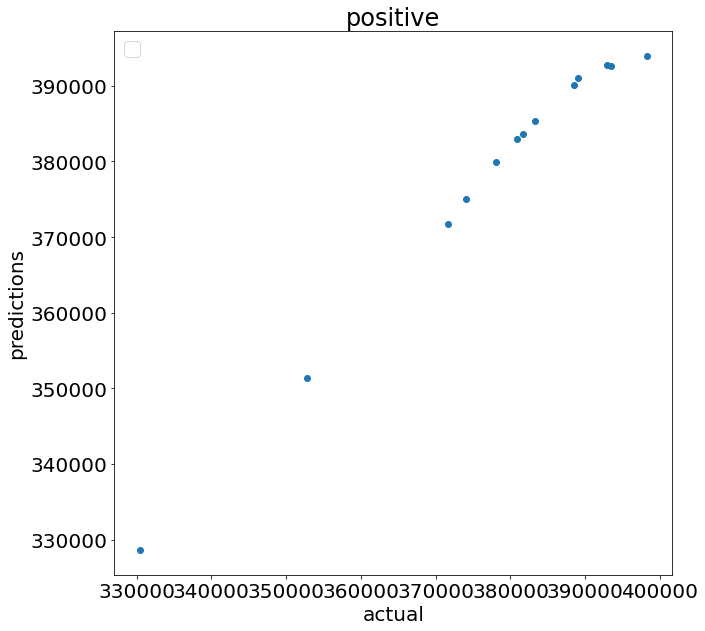

In [ ]:
LinearReg(df_new_york)

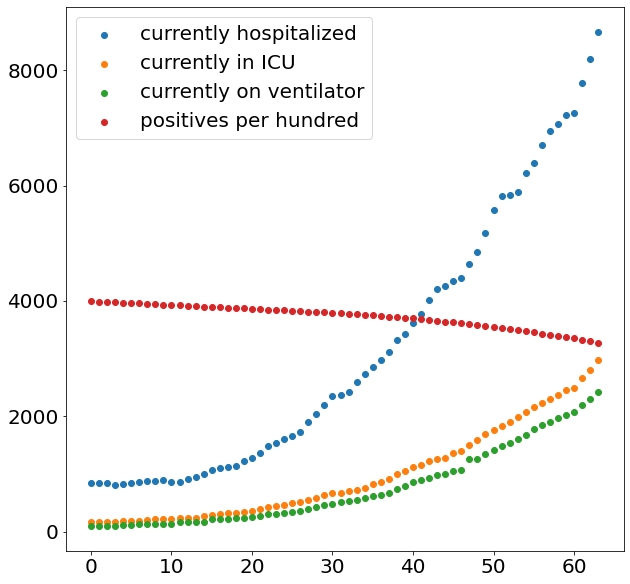

In [ ]:
plt.scatter(df_new_york.index,df_new_york["hospitalizedCurrently"], label='currently hospitalized')
plt.scatter(df_new_york.index,df_new_york["inIcuCurrently"], label='currently in ICU')
plt.scatter(df_new_york.index,df_new_york["onVentilatorCurrently"], label='currently on ventilator')
plt.scatter(df_new_york.index,df_new_york["positive"]/100, label='positives per hundred')
plt.legend(loc='upper left')
plt.show()

##2. In specific African countries, which groups of people had access to testing and how did testing policies progress in Ghana after first $5000^{th}$, $10000^{th}$, $15000^{th}$ and $20000^{th}$ cases of COVID was recorded?

###Preparing Dataset(s)

In [ ]:
#get dataframe ready:
#change to read "latestdata" from the indicators folder
df_lockdown = pd.read_csv("lockdown_world.csv")
#convert to date time object
df_lockdown["Date"] = pd.to_datetime(df_lockdown["Date"], format= "%Y%m%d")

#drop duplicated data from dataframe
print("lockdown:", df_lockdown.duplicated().sum())
df_lockdown = df_lockdown.drop_duplicates(keep = 'first')

# df_new_york = df_new_york[::-1] 
# prep_df("new_york_daily.csv","df_new_york")
df_lockdown.head()

lockdown: 0


CountryName CountryCode  ... EconomicSupportIndex  EconomicSupportIndexForDisplay
0       Aruba         ABW  ...                  0.0                             0.0
1       Aruba         ABW  ...                  0.0                             0.0
2       Aruba         ABW  ...                  0.0                             0.0
3       Aruba         ABW  ...                  0.0                             0.0
4       Aruba         ABW  ...                  0.0                             0.0

[5 rows x 42 columns]

In [ ]:
#extract column of interest
df_testing = df_lockdown[["CountryName","Date", "H2_Testing policy"]]
df_testing = df_testing.dropna() #drop missing columns 
df_testing = df_testing.dropna(axis=0) #drop missing rows

#reindex everything
df_testing = df_testing.reset_index(drop=True)

#lower case all
df_testing = df_testing.apply(lambda x: x.astype(str).str.lower() if(x.dtype == 'object') else x)

df_testing.head()

#extract for African countries only
#lowercase of each country name:
WA_list = [string.lower() for string in WA_list]
WAindexlist = []
counter = 0
for i in df_testing['CountryName']:
  if i in WA_list:
      WAindexlist.append(counter)
  counter +=1
# print(WAindexlist)

#Extract those rows of the dataframe
df_testing = df_testing.loc[WAindexlist]
df_testing.head() 
print("The number of African countries represented are", len(df_testing["CountryName"].unique())) #all 52 african countries represented

The number of African countries represented are 46


**Ordinal Scale for Testing Policy:**
* 0 - no testing policy
* 1 - only those who both:
  * have symptoms AND
  * meet specific criteria (eg key workers, admitted to hospital, came into contact with a known case, returned from overseas)
* 2 - testing of anyone showing Covid-19 symptoms
* 3 - open public testing (eg "drive through" testing available to asymptomatic people)
* Blank - no data

### Visualisations (Africa)

<BarContainer object of 46 artists>

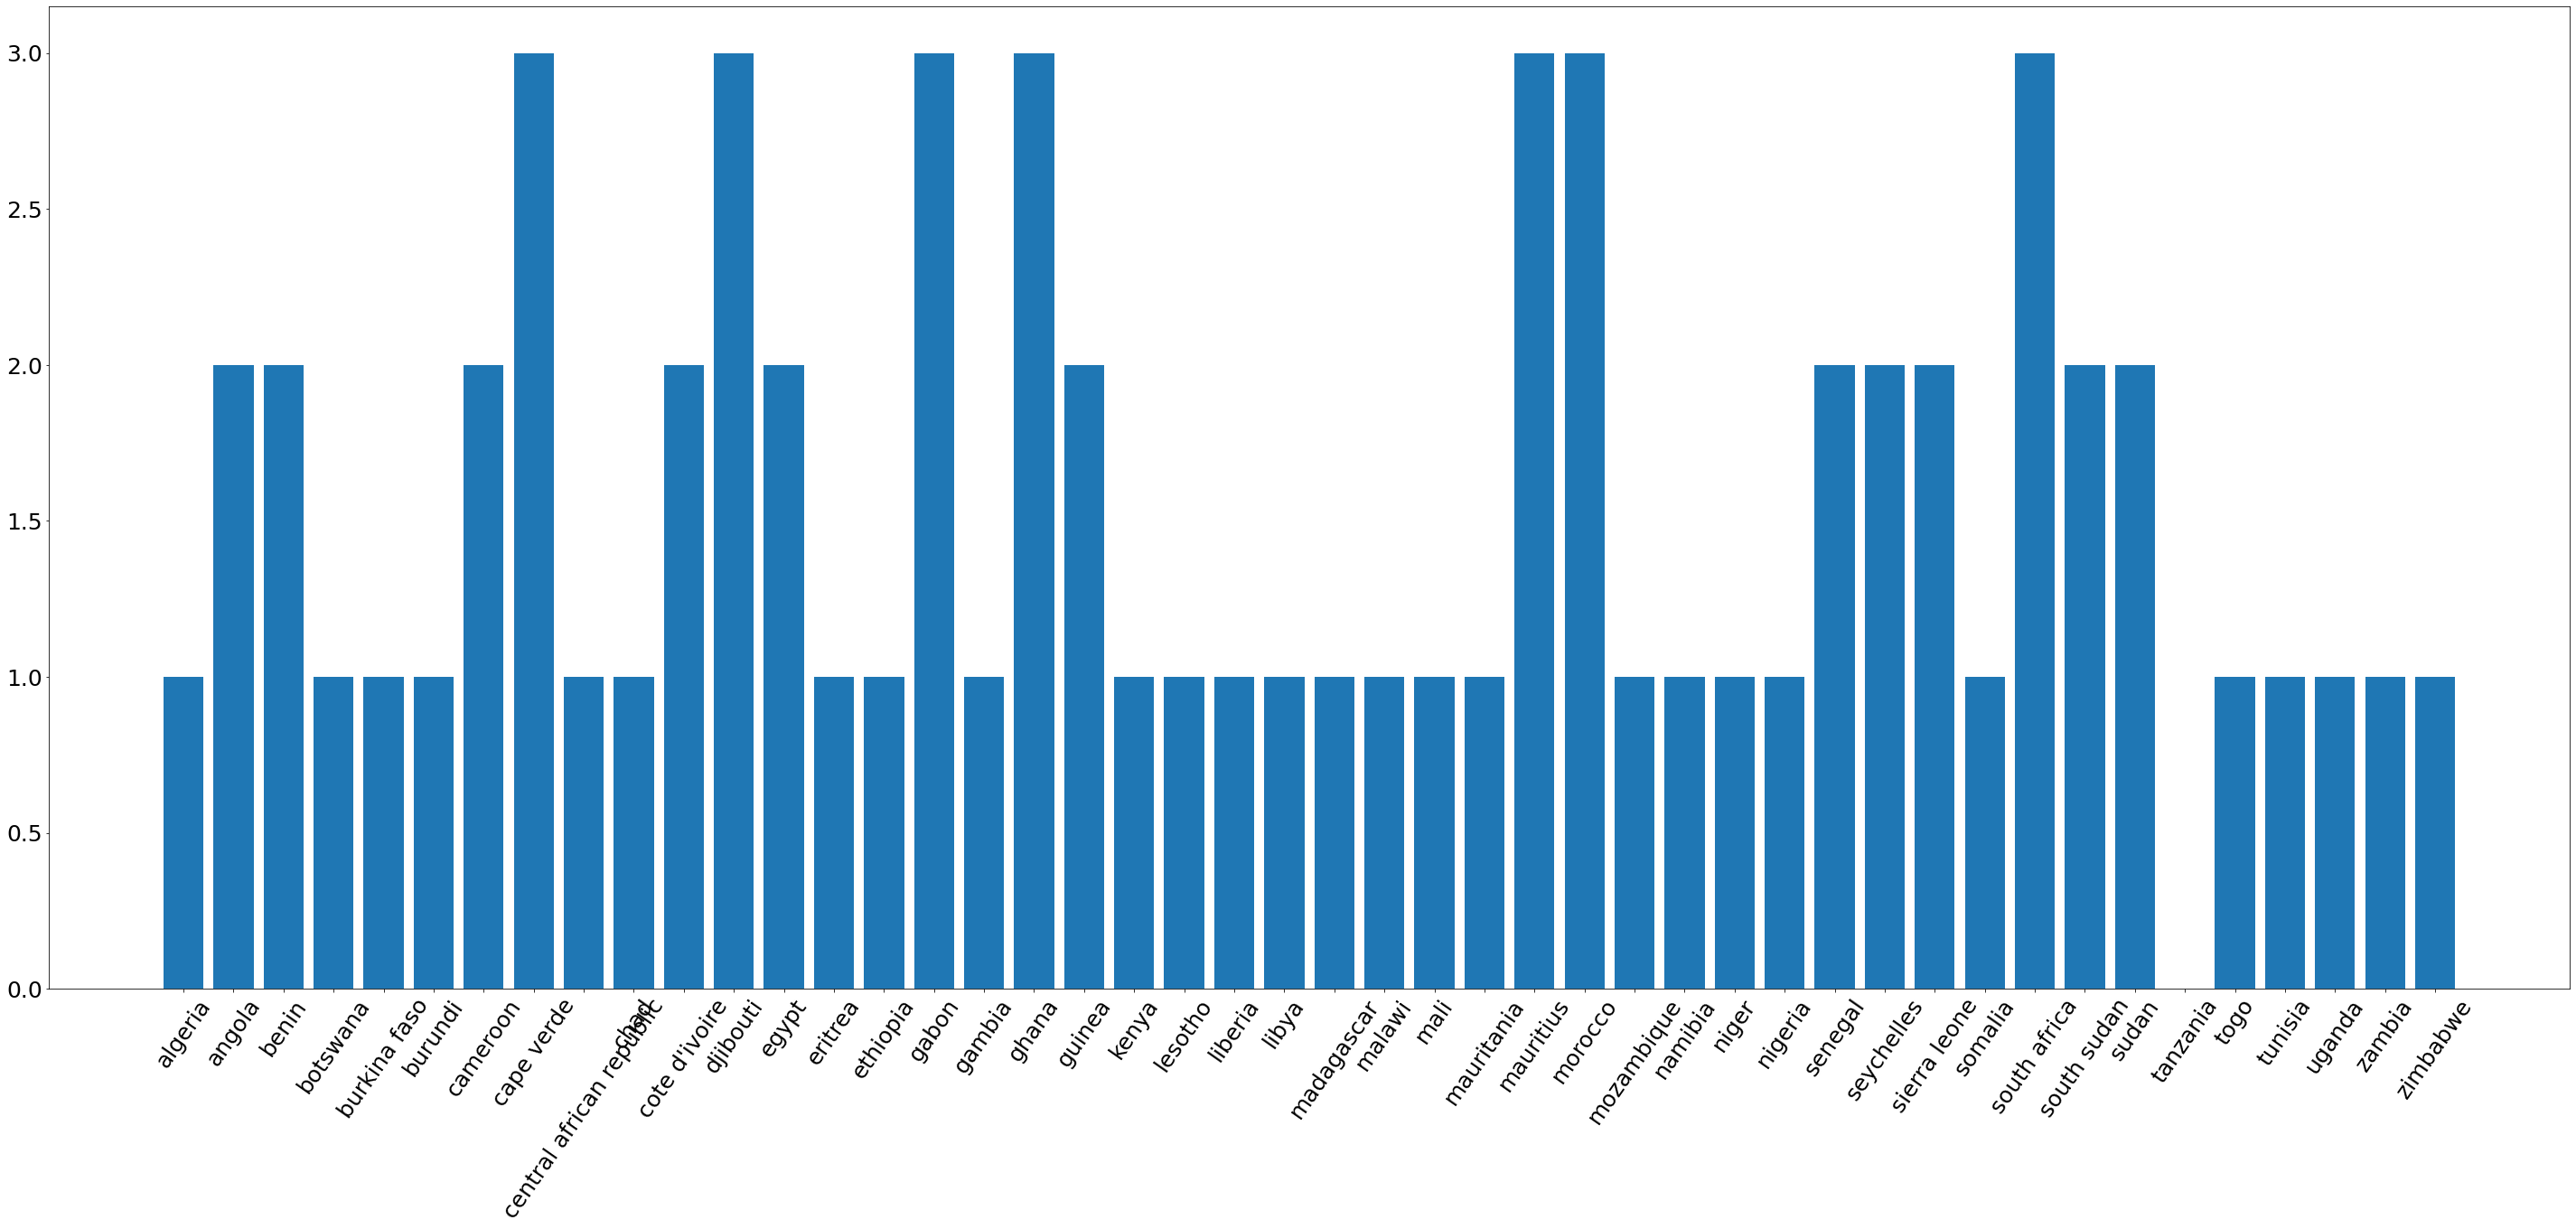

In [ ]:
#for each country, do histogram of how strict they were on testing policy:
df_testing_group = pd.DataFrame(df_testing.groupby(['CountryName'])["H2_Testing policy"].max()) 
df_testing_group = df_testing_group.add_suffix('').reset_index() #changed groupby to a dataframe
df_testing_group.head()
plt.rcParams['figure.figsize'] = [50, 20]
plt.rc('font', size=25)
plt.xticks(rotation=55)
plt.bar(df_testing_group["CountryName"],df_testing_group["H2_Testing policy"])

### Visualisations (Ghana)

In [ ]:
#filter out Ghana data only
df_testing_ghana = df_testing.loc[df_testing["CountryName"]=="ghana"]
df_testing_ghana.head()

#create a dataframe on when first case was detected and also when number of
#cases reached 5,000, 10,000, 15,000 and 20,000 and map
df_firsts_ghana = pd.read_csv("full_data.csv")
#convert to date time object
df_firsts_ghana["date"] = pd.to_datetime(df_firsts_ghana["date"], format= "%Y-%m-%d")
#drop duplicated data from dataframe
print("lockdown:", df_firsts_ghana.duplicated().sum())
df_firsts_ghana = df_firsts_ghana.drop_duplicates(keep = 'first')
df_firsts_ghana.head()

df_firsts_ghana= df_firsts_ghana[["date","total_cases","location"]]
df_firsts_ghana = df_firsts_ghana.loc[df_firsts_ghana["location"]=="Ghana"]
df_firsts_ghana1 = df_firsts_ghana.loc[df_firsts_ghana["total_cases"]==2]
df_firsts_ghana2 = df_firsts_ghana.loc[df_firsts_ghana["total_cases"]==5127]
df_firsts_ghana3 = df_firsts_ghana.loc[df_firsts_ghana["total_cases"]==15013]
df_firsts_ghana4 = df_firsts_ghana.loc[df_firsts_ghana["total_cases"]==20085]

#merge them all:
frames = [df_firsts_ghana1,df_firsts_ghana2,df_firsts_ghana3,df_firsts_ghana4]
result = pd.concat(frames)
result
df_firsts_ghana = df_firsts_ghana.merge(result, left_on='date', right_on='date')
df_firsts_ghana.head()

# plt.bar(df_firsts_ghana["date"], df_firsts_ghana["total_cases_x"], linestyle='--')
# plt.show()

lockdown: 0


date  total_cases_x location_x  total_cases_y location_y
0 2020-03-13            2.0      Ghana            2.0      Ghana
1 2020-03-15            2.0      Ghana            2.0      Ghana
2 2020-03-16            2.0      Ghana            2.0      Ghana
3 2020-05-13         5127.0      Ghana         5127.0      Ghana
4 2020-06-25        15013.0      Ghana        15013.0      Ghana

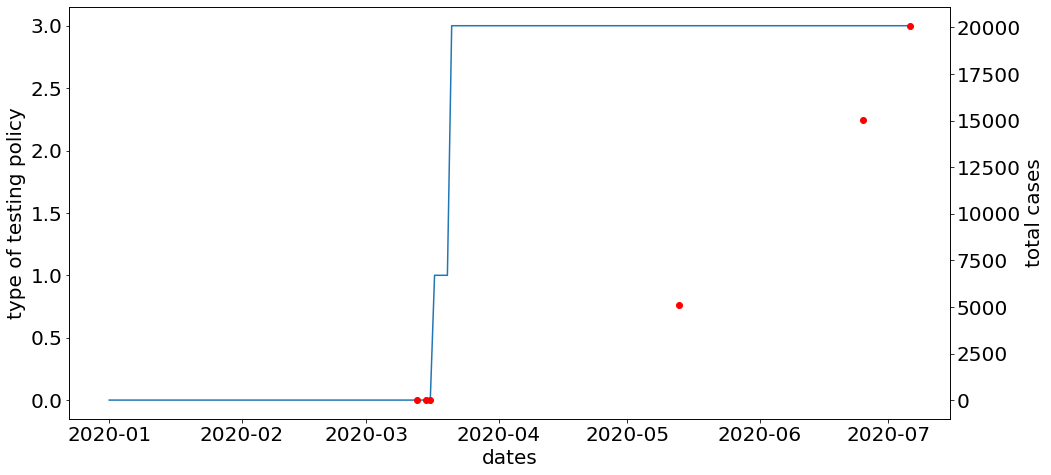

In [ ]:
#graph the progression of COVID testing policies in Ghana 
plt.rcParams['figure.figsize'] = [15, 7]
plt.rc('font', size=20)

fig, ax1 = plt.subplots()

ax1.set_xlabel('dates')
ax1.set_ylabel('type of testing policy')
ax1.plot(df_testing_ghana["Date"], df_testing_ghana["H2_Testing policy"])
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('total cases')  # we already handled the x-label with ax1
ax2.scatter(df_firsts_ghana["date"], df_firsts_ghana["total_cases_x"], c="r")
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Pie Chart (Africa)

0
The number of African countries represented are 52


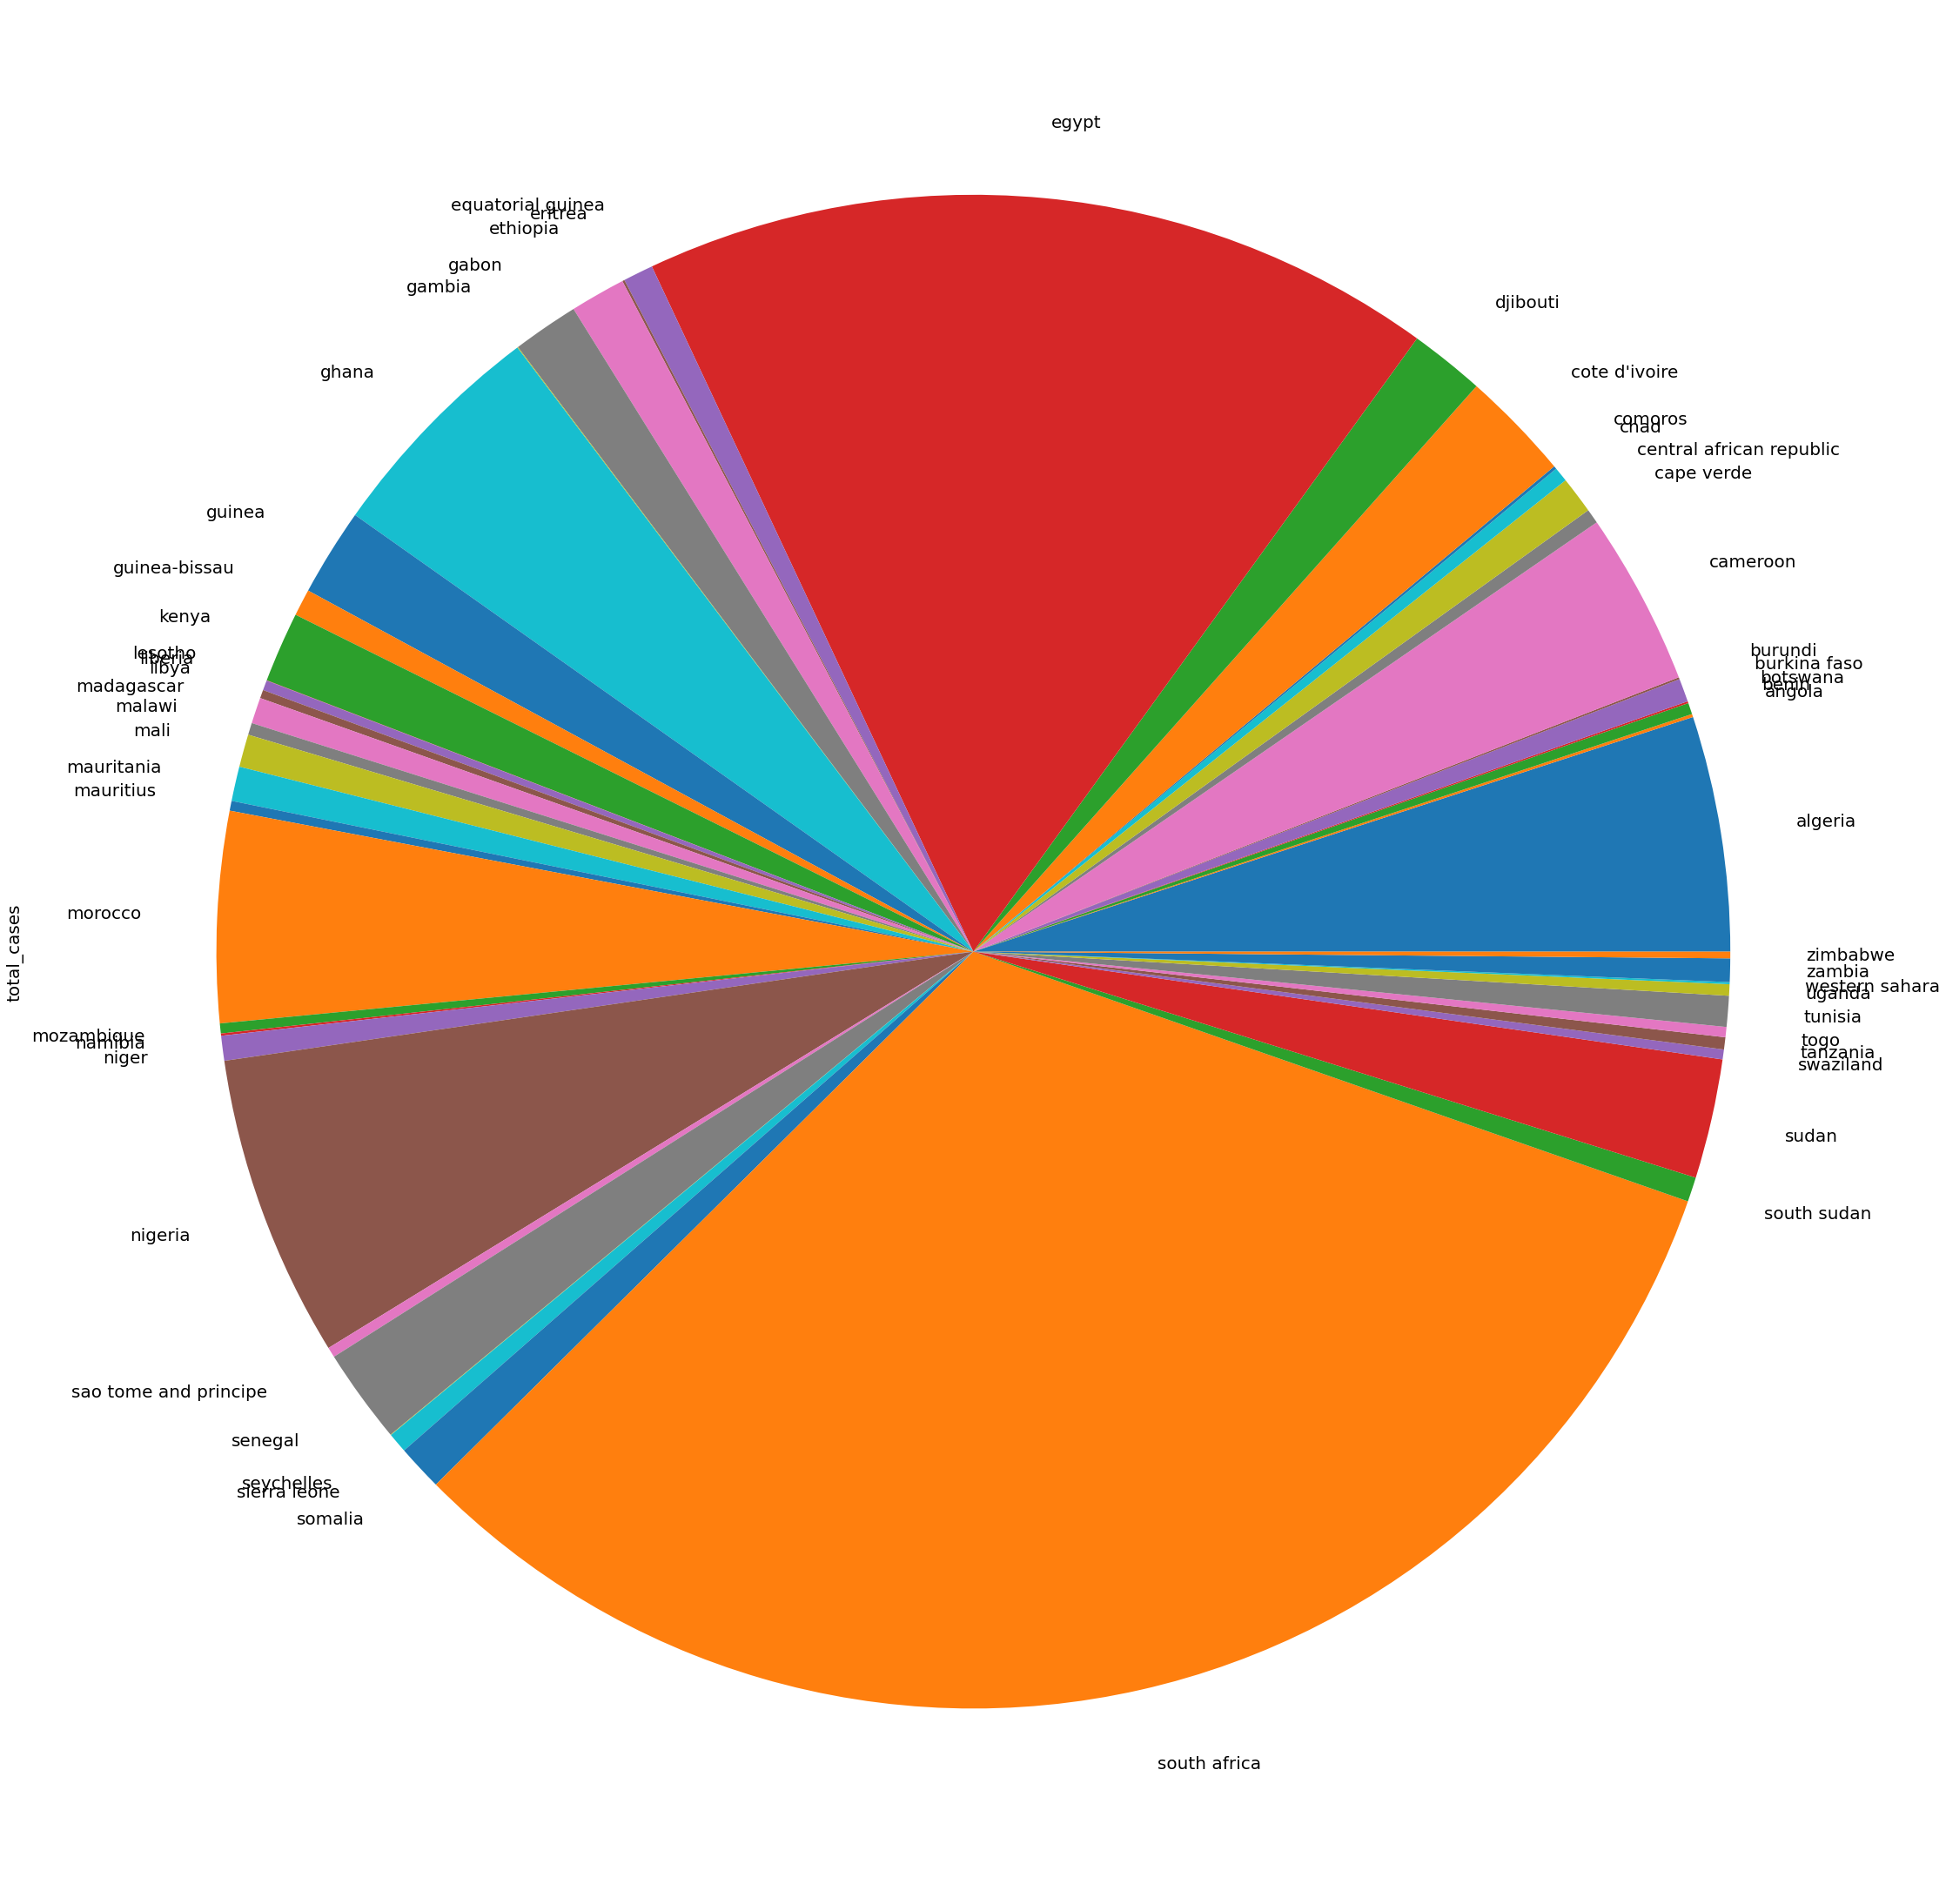

In [ ]:
#do pie chart
df_pie_charts = pd.read_csv("full_data.csv")
df_pie_charts = df_pie_charts.dropna() #drop missing columns 
df_pie_charts = df_pie_charts.dropna(axis=0) #drop missing rows

#convert to date time object
df_pie_charts["date"] = pd.to_datetime(df_pie_charts["date"], format= "%Y-%m-%d")
#drop duplicated data from dataframe
print(df_pie_charts.duplicated().sum())
df_pie_charts = df_pie_charts.drop_duplicates(keep = 'first')
df_pie_charts = df_pie_charts[["date","location","total_cases"]]
df_pie_charts.head()

#reindex everything
df_pie_charts = df_pie_charts.reset_index(drop=True)

df_pie_charts = df_pie_charts.apply(lambda x: x.astype(str).str.lower() if(x.dtype == 'object') else x)

#extract for African countries only
#lowercase of each country name:
WA_list = [string.lower() for string in WA_list]
WAindexlist = []
counter = 0
for i in df_pie_charts['location']:
  if i in WA_list:
      WAindexlist.append(counter)
  counter +=1

#Extract those rows of the dataframe
df_pie_charts = df_pie_charts.loc[WAindexlist]
df_pie_charts.head() 
print("The number of African countries represented are", len(df_pie_charts["location"].unique())) #all 52 african countries represented

df_pie_charts = pd.DataFrame(df_pie_charts.groupby(['location'])["total_cases"].sum()) #summed number of cases per day
df_pie_charts = df_pie_charts.add_suffix('').reset_index() #changed groupby to a dataframe
df_pie_charts.head()
df_pie_charts.plot.pie(labels = df_pie_charts["location"].unique(), 
                       y='total_cases', figsize=(40,40),legend = False)

##3. By what percentage did the rate of spread of the virus change in countries with stricter lockdowns and countries with more flexible lockdowns? *(might have to further refine what has been done here since its possible reduced and increased the strictness of their lockdown policies)*
Description of lockdown policies are here: https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md

With respect to containment and closure policies, the types include: 
* School closing (0-3)
* Workplace closing (0-3)
* Cancel public events (0-2)
* Restrictions on gatherings (0-4)
* Close public transport (0-2)
* Stay at home requirements (0-3)
* Restrictions on internal movement (0-2)
* International travel controls (0-4)


###Preparing Dataset(s)

In [ ]:
#get dataframe ready:
df_lockdown = pd.read_csv("OxCGRT_latest.csv")

#drop duplicated data from dataframe
print("lockdown duplicates:", df_lockdown.duplicated().sum())
df_lockdown = df_lockdown.drop_duplicates(keep = 'first')

#extract columns of interest
df_lockdown.columns
df_lockdown = df_lockdown[['CountryName', 'CountryCode', 'Date', 'C1_School closing',
       'C2_Workplace closing', 'C3_Cancel public events','C4_Restrictions on gatherings',
       'C5_Close public transport','C6_Stay at home requirements',
       'C7_Restrictions on internal movement', 'C8_International travel controls']]
df_lockdown = df_lockdown.dropna() #drop missing columns 
df_lockdown = df_lockdown.dropna(axis=0) #drop missing rows
df_lockdown.head()

#extract for African countries only
WA_list = ["Algeria","Angola","Benin","Botswana","Burkina Faso","Burundi","Cameroon","Cape Verde",
           "Central African Republic","Chad","Comoros","Congo-Brazzaville","Congo-Kinshasa","Cote d'Ivoire",
           "Djibouti","Egypt","Equatorial Guinea","Eritrea","Ethiopia","Gabon","Gambia","Ghana",
           "Guinea","Guinea Bissau","Kenya","Lesotho","Liberia","Libya","Madagascar","Malawi",
           "Mali","Mauritania","Mauritius","Morocco","Mozambique","Namibia","Niger","Nigeria","Rwanda"
           "Senegal","Seychelles","Sierra Leone","Somalia","South Africa","South Sudan","Sudan","Swaziland",
           "São Tomé and Príncipe","Tanzania","Togo","Tunisia","Uganda","Western Sahara","Zambia","Zimbabwe","Burkina Faso", "Cameroon", "Cote d’Ivoire", "Ghana", "Nigeria", 
            "Senegal", "Ivory Coast", "Côte d'Ivoire", "Benin", "Burkina Faso", "Cape Verde", 
            "Cabo Verde", "The Gambia", "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Guinea Bissau"
           "Ivory Coast", "Cote d’Ivoire", "Côte d'Ivoire", "Liberia", "Mali", 
           "Mauritania", "Niger", "Nigeria", "Senegal", "Sierra Leone","Togo",
           "Saint Helena","St Helena", "St. Helena","Sao Tome and Principe", 
           "Sao Tome & Principe", "Cameroon"]

#lowercase of each country name:
WA_list = [string.lower() for string in WA_list]
df_lockdown['CountryName'] = df_lockdown['CountryName'].str.lower()
WAindexlist = []
counter = 0
for i in df_lockdown['CountryName']:
  if i in WA_list:
      WAindexlist.append(counter)
  counter +=1
# print(WAindexlist)

#Extract those rows of the dataframe
df_lockdown_Africa = df_lockdown.iloc[WAindexlist]
df_lockdown_Africa.head() 
print("The number of African countries represented are", len(df_lockdown_Africa["CountryName"].unique())) #all 52 african countries represented

lockdown duplicates: 0
The number of African countries represented are 46


In [ ]:
#find date that each African country introduced each level of restriction
df_lockdown_Africa_strict = df_lockdown_Africa.loc[(df_lockdown_Africa["C1_School closing"]==3) &
                                                       (df_lockdown_Africa["C2_Workplace closing"]==3) &
                                                       (df_lockdown_Africa["C3_Cancel public events"]==2) &
                                                       (df_lockdown_Africa["C4_Restrictions on gatherings"]==4) &
                                                       (df_lockdown_Africa["C5_Close public transport"]==2) &
                                                       (df_lockdown_Africa["C6_Stay at home requirements"]==3) &
                                                       (df_lockdown_Africa["C7_Restrictions on internal movement"]==2) &
                                                       (df_lockdown_Africa["C8_International travel controls"]==4)]
df_lockdown_Africa_strict.head()
for i in df_lockdown_Africa_strict.columns:
  print(df_lockdown_Africa_strict[i].unique())
print (*df_lockdown_Africa_strict["CountryName"].unique(),"had the strictest lockdown policies.")

['djibouti' 'algeria' 'libya']
['DJI' 'DZA' 'LBY']
[20200425 20200426 20200427 20200428 20200429 20200430 20200501 20200502
 20200503 20200504 20200505 20200506 20200507 20200508 20200509 20200510
 20200330 20200331 20200401 20200402 20200403 20200404 20200405 20200406
 20200407 20200408 20200409 20200410 20200411 20200412 20200413 20200414
 20200415 20200416 20200417 20200418 20200419 20200420 20200421 20200422
 20200423 20200424 20200511 20200512 20200513 20200514 20200515 20200516
 20200517 20200518 20200519 20200520 20200521 20200522 20200523 20200524
 20200525 20200526 20200527]
[3.]
[3.]
[2.]
[4.]
[2.]
[3.]
[2.]
[4.]
djibouti algeria libya had the strictest lockdown policies.


In [ ]:
#find date that each African country introduced each level of restriction
df_lockdown_Africa_lenient = df_lockdown_Africa.loc[(df_lockdown_Africa["C1_School closing"]==0) &
                                                       (df_lockdown_Africa["C2_Workplace closing"]==0) &
                                                       (df_lockdown_Africa["C3_Cancel public events"]==0) &
                                                       (df_lockdown_Africa["C4_Restrictions on gatherings"]==0) &
                                                       (df_lockdown_Africa["C5_Close public transport"]==0) &
                                                       (df_lockdown_Africa["C6_Stay at home requirements"]==0) &
                                                       (df_lockdown_Africa["C7_Restrictions on internal movement"]==0) &
                                                       (df_lockdown_Africa["C8_International travel controls"]==0)& 
                                                    (df_lockdown_Africa["Date"]>=20200318)]
df_lockdown_Africa_lenient.head()
for i in df_lockdown_Africa_lenient.columns:
  print(df_lockdown_Africa_lenient[i].unique())
print (*df_lockdown_Africa_lenient["CountryName"].unique(),"had the most lenient lockdown policies.")

['central african republic' 'mali' 'malawi']
['CAF' 'MLI' 'MWI']
[20200318 20200319 20200320 20200321 20200322 20200323 20200324 20200325]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
central african republic mali malawi had the most lenient lockdown policies.


In [ ]:
#for each country, find first case of each restriction value
for i in df_lockdown_Africa_strict["CountryName"].unique():
  dummy = df_lockdown_Africa_strict.loc[df_lockdown_Africa_strict["CountryName"]==i]
  print(dummy["CountryName"].unique(), dummy["Date"].unique()[0])
for i in df_lockdown_Africa_lenient["CountryName"].unique():
  dummy = df_lockdown_Africa_lenient.loc[df_lockdown_Africa_lenient["CountryName"]==i]
  print(dummy["CountryName"].unique(), dummy["Date"].unique()[0])

['djibouti'] 20200425
['algeria'] 20200330
['libya'] 20200417
['central african republic'] 20200318
['mali'] 20200318
['malawi'] 20200318


### Visualisations (Strict and Lenient Countries)

lockdown: 0


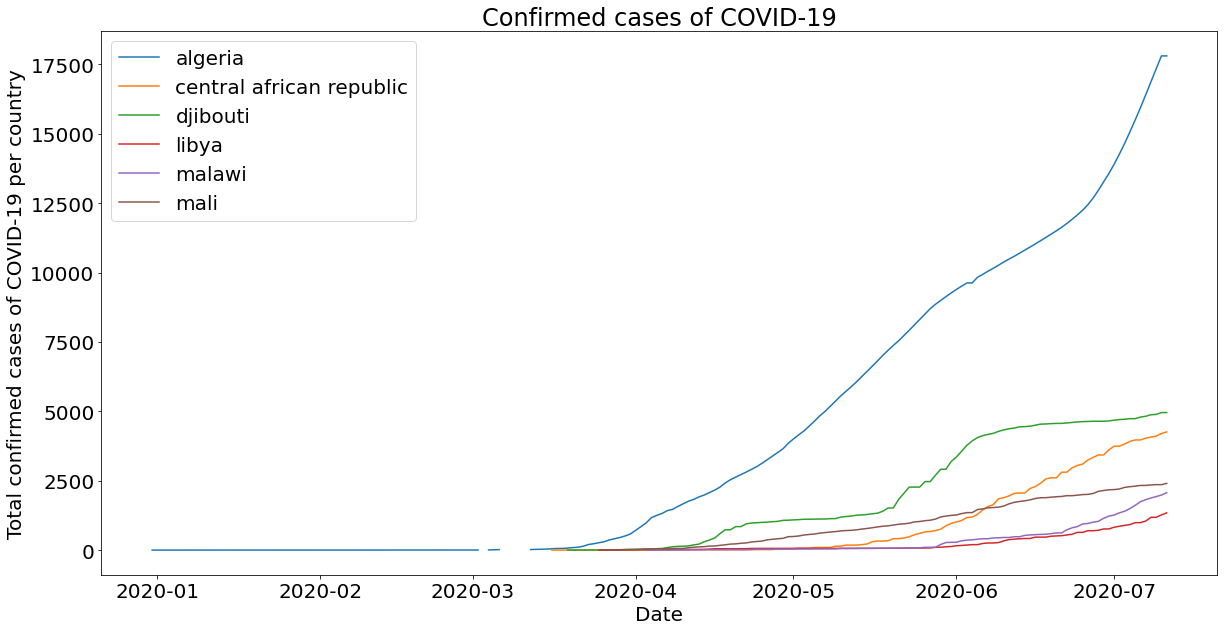

In [ ]:
#for each strict and lenient country, plot the trend on the virus and create a 
# marker at the needed dates

#first just graph for each country: djibouti algeria libya, central african republic mali malawi 
trend_graph = pd.read_csv("full_data.csv")
trend_graph['location'] = trend_graph['location'].str.lower()

#convert to date time object
trend_graph["date"] = pd.to_datetime(trend_graph["date"], format= "%Y-%m-%d")

#drop duplicated data from dataframe
print("lockdown:", trend_graph.duplicated().sum())
trend_graph = trend_graph.drop_duplicates(keep = 'first')
trend_graph = trend_graph.loc[trend_graph["location"].isin(["djibouti", "algeria",
                                                        "libya", "central african republic",
                                                        "mali", "malawi"])]
trend_graph.head()

#graph for each country (on the same graph?)
plt.figure(figsize=(20,10))
for key, grp in trend_graph.groupby(['location']): 
  grp1 = grp['total_cases']
  # y = grp1.cumsum()
  plt.plot(grp['date'], grp1, label = key)
plt.legend(loc='best')    
plt.xlabel("Date")
plt.ylabel("Total confirmed cases of COVID-19 per country")
plt.title("Confirmed cases of COVID-19")
plt.show()

### Visualisations (Djibouti, Algeria, Libya, Central Africa Republic, Mali, Malawi)

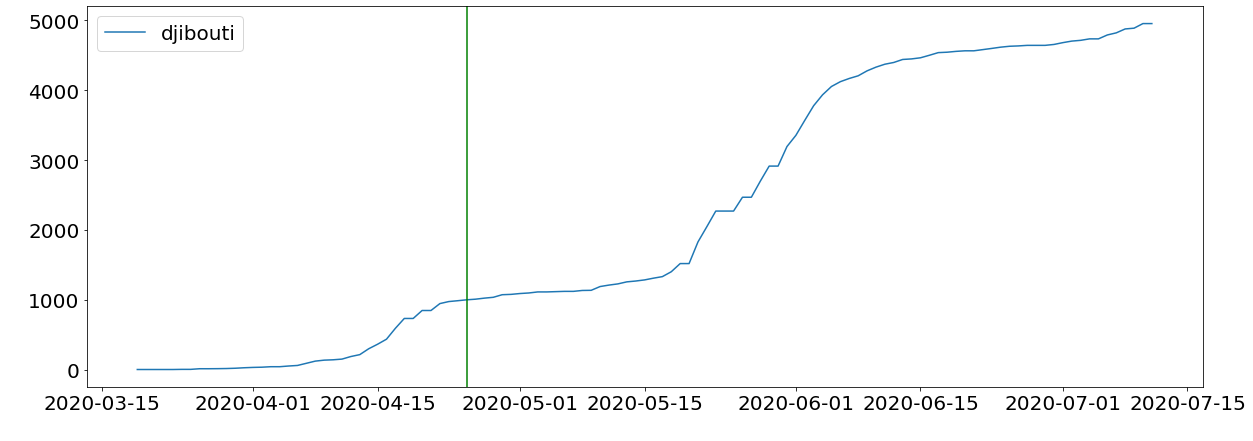

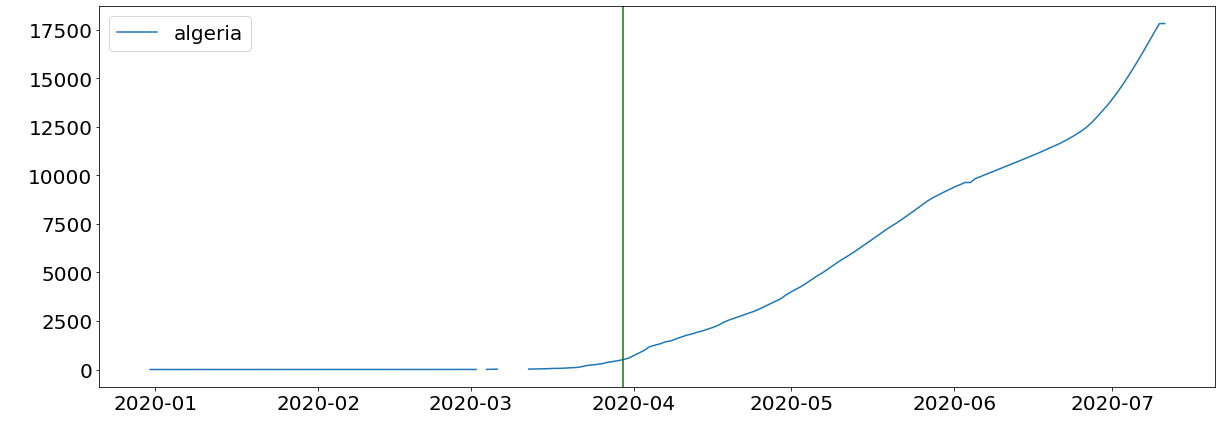

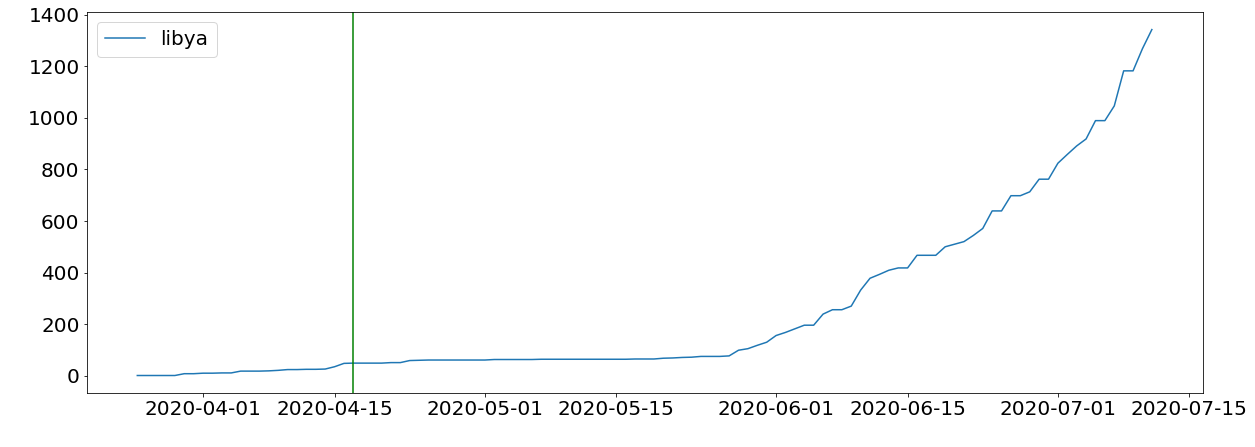

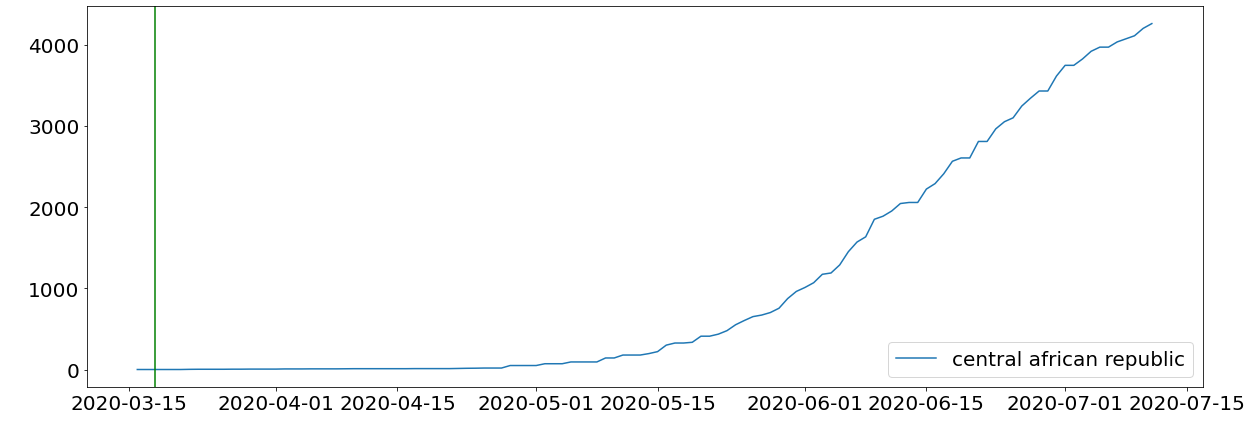

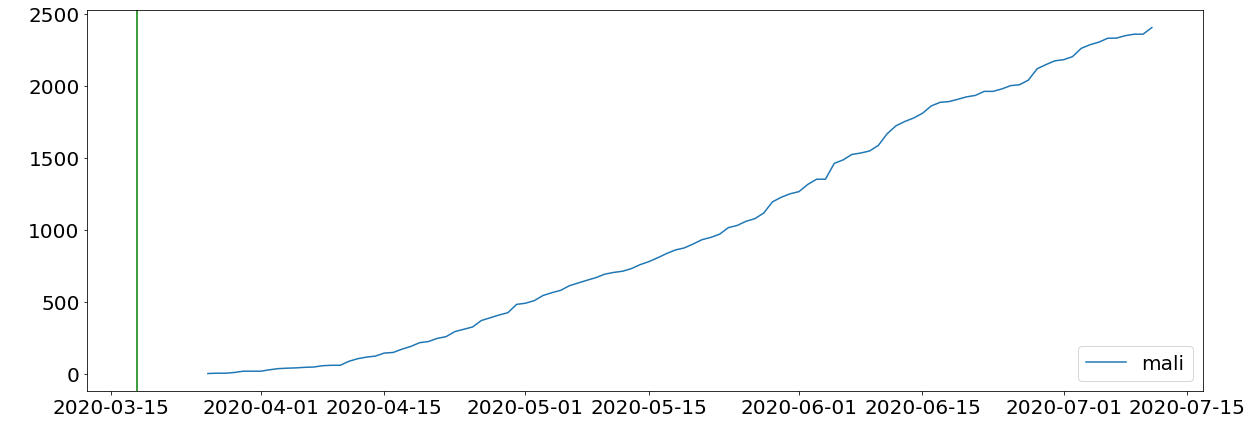

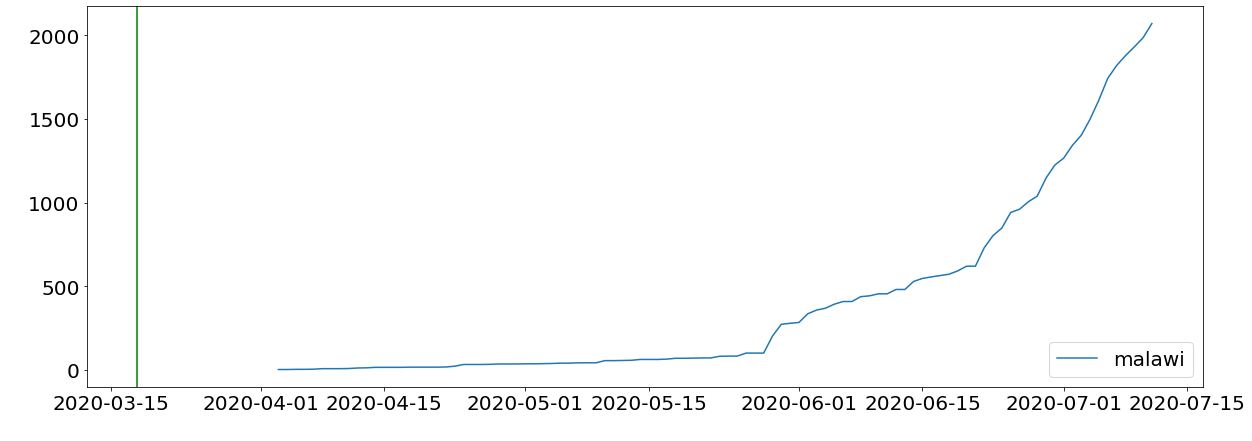

In [ ]:
#do singly for each country
date_list = ['20-04-25', '20-03-30', '20-04-17', '20-03-18', '20-03-18', '20-03-18']
counter = 0
for i in ['djibouti', 'algeria', 'libya', 'central african republic', 'mali', 'malawi']:
   df5 = trend_graph.loc[trend_graph["location"]==i]
   #4. Plot!
   font = {'family': 'serif',
         'color':  'white',
        'weight': 'normal',
        'size': 16}
   plt.rcParams['figure.figsize'] = [20,7]
   plt.rc('font', size=20)
   plt.plot(df5["date"],df5["total_cases"],label=i)
   plt.axvline(x=datetime.strptime(date_list[counter],"%y-%m-%d"), ymin=0, ymax=1,color="green")   
   plt.legend()
   plt.xlabel("Days",fontdict=font)
   plt.ylabel("Total Cases",fontdict=font)
   plt.show()
   counter+=1

### Explorations

In [ ]:
#filter out Ghana data only
df_lockdown_Ghana = df_lockdown_Africa.loc[df_lockdown_Africa["CountryName"]=="libya"]
df_lockdown_Ghana.head()
for i in df_lockdown_Ghana.columns:
  print(df_lockdown_Ghana[i].unique())

['libya']
['LBY']
[20200101 20200102 20200103 20200104 20200105 20200106 20200107 20200108
 20200109 20200110 20200111 20200112 20200113 20200114 20200115 20200116
 20200117 20200118 20200119 20200120 20200121 20200122 20200123 20200124
 20200125 20200126 20200127 20200128 20200129 20200130 20200131 20200201
 20200202 20200203 20200204 20200205 20200206 20200207 20200208 20200209
 20200210 20200211 20200212 20200213 20200214 20200215 20200216 20200217
 20200218 20200219 20200220 20200221 20200222 20200223 20200224 20200225
 20200226 20200227 20200228 20200229 20200301 20200302 20200303 20200304
 20200305 20200306 20200307 20200308 20200309 20200310 20200311 20200312
 20200313 20200314 20200315 20200316 20200317 20200318 20200319 20200320
 20200321 20200322 20200323 20200324 20200325 20200326 20200327 20200328
 20200329 20200330 20200331 20200401 20200402 20200403 20200404 20200405
 20200406 20200407 20200408 20200409 20200410 20200411 20200412 20200413
 20200414 20200415 20200416 20200

Ideas:
*   When doing the write up, look at what current research has shown and reference it in your work too
*"epidemiological trajectory of COVID?"

# Conclusion

# References 
https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d (logistic model)
https://www.tensorflow.org/tutorials/structured_data/time_series
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb#scrollTo=0opH9xi5MtIk

https://ourworldindata.org/covid-deaths (for sir model)
https://github.com/beoutbreakprepared/nCoV2019 (for nltk)

https://coronavirus.jhu.edu/testing/individual-states/california (for ventilators)

https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv , https://github.com/OxCGRT/covid-policy-tracker (for lockdown)

https://ourworldindata.org/coronavirus-source-data (for part of testing)

https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md (lockdown)
